# Data Mining Project 2021/22 Group AU

Yuriy Perezhohin, number: m20210767
Joao Silva, number: m20211014
Andreas Schneeweiss, number: m20211203


In [687]:
#!pip install kmodes
import os
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from pandas_profiling import ProfileReport
from math import ceil
from sklearn.base import clone
from scipy.cluster.vq import whiten
import warnings
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
warnings.filterwarnings('ignore')
from collections import Counter, defaultdict
import time
import os

# Third party imports
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from kmodes.kprototypes import KPrototypes
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
#!pip install plotnine
from plotnine import *
import plotnine

import seaborn as sns



# Seeting seaborn style
sns.set()

In [688]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

## Initial Analysis


In [689]:
file= pd.read_sas('a2z_insurance.sas7bdat')
file.head()

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [690]:
file.drop('CustID',axis=1,inplace=True)

In [691]:
file.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
FirstPolYear,10266.0,NaN,NaN,NaN,1991.062634,511.267913,1974.0,1980.0,1986.0,1992.0,53784.0
BirthYear,10279.0,NaN,NaN,NaN,1968.007783,19.709476,1028.0,1953.0,1968.0,1983.0,2001.0
EducDeg,10279,4,b'3 - BSc/MSc',4799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,10260.0,NaN,NaN,NaN,2506.667057,1157.449634,333.0,1706.0,2501.5,3290.25,55215.0
GeoLivArea,10295.0,NaN,NaN,NaN,2.709859,1.266291,1.0,1.0,3.0,4.0,4.0
Children,10275.0,NaN,NaN,NaN,0.706764,0.455268,0.0,0.0,1.0,1.0,1.0
CustMonVal,10296.0,NaN,NaN,NaN,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89
ClaimsRate,10296.0,NaN,NaN,NaN,0.742772,2.916964,0.0,0.39,0.72,0.98,256.2
PremMotor,10262.0,NaN,NaN,NaN,300.470252,211.914997,-4.11,190.59,298.61,408.3,11604.42
PremHousehold,10296.0,NaN,NaN,NaN,210.431192,352.595984,-75.0,49.45,132.8,290.05,25048.8


In [692]:
file.dtypes

FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [693]:
non_metric_features = ["EducDeg","GeoLivArea","Children"]
metric_features = file.columns.drop(non_metric_features).to_list()
metric_features

['FirstPolYear',
 'BirthYear',
 'MonthSal',
 'CustMonVal',
 'ClaimsRate',
 'PremMotor',
 'PremHousehold',
 'PremHealth',
 'PremLife',
 'PremWork']

### Fill Missing Values with KNN imputer

In [694]:
file['EducDeg'].fillna(file['EducDeg'].mode()[0], inplace=True)
file['GeoLivArea'].fillna(file['GeoLivArea'].mode()[0], inplace=True)
file['Children'].fillna(file['Children'].mode()[0], inplace=True)

file_missing = file.copy()

In [695]:
file_missing[file_missing.isna().any(axis=1)] # maybe its best option to fill this nan values with KNN method or mice or we can drop them because 309 rows its
# exactly 3 % of our data and we shouldnot drop more than 3 %
# or we can just use mean or median of each column
# as we saw previously in the statistical functions the std error its too big to use only the median and not the mean
nan_index= file_missing.isna().any(axis=1)
file_missing.isna().any()

FirstPolYear      True
BirthYear         True
EducDeg          False
MonthSal          True
GeoLivArea       False
Children         False
CustMonVal       False
ClaimsRate       False
PremMotor         True
PremHousehold    False
PremHealth        True
PremLife          True
PremWork          True
dtype: bool

In [696]:
file_missing

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10291,1984.0,1949.0,b'4 - PhD',3188.0,2.0,0.0,-0.11,0.96,393.74,49.45,173.81,9.78,14.78
10292,1977.0,1952.0,b'1 - Basic',2431.0,3.0,0.0,1405.60,0.00,133.58,1035.75,143.25,12.89,105.13
10293,1994.0,1976.0,b'3 - BSc/MSc',2918.0,1.0,1.0,524.10,0.21,403.63,132.80,142.25,12.67,4.89
10294,1981.0,1977.0,b'1 - Basic',1971.0,2.0,1.0,250.05,0.65,188.59,211.15,198.37,63.90,112.91


In [697]:
missing=file_missing.columns.drop(["EducDeg",'GeoLivArea','Children']).to_list()
scaler=StandardScaler().fit(file_missing[missing])
x = scaler.transform(file_missing[missing])
imputer= KNNImputer(n_neighbors=5,weights='uniform')
x =imputer.fit_transform(x)
x = scaler.inverse_transform(x)
x = pd.DataFrame(x)

file_missing = x
file_missing=file_missing.rename({0:'FirstPolYear',1:'BirthYear',2:'MonthSal',3:'CustMonVal',4:'ClaimsRate',5:'PremMotor',6:'PremHousehold',7:'PremHealth',8:'PremLife',9:'PremWork'},axis = 1)
file_missing['EducDeg']=file['EducDeg']
file_missing['GeoLivArea']=file['GeoLivArea']
file_missing['Children']=file['Children']


In [698]:
file_missing

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg,GeoLivArea,Children
0,1985.0,1982.0,2177.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89,b'2 - High School',1.0,1.0
1,1981.0,1995.0,677.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,b'2 - High School',4.0,1.0
2,1991.0,1970.0,2277.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02,b'1 - Basic',3.0,0.0
3,1990.0,1981.0,1099.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,b'3 - BSc/MSc',4.0,1.0
4,1986.0,1973.0,1763.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45,b'3 - BSc/MSc',4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10291,1984.0,1949.0,3188.0,-0.11,0.96,393.74,49.45,173.81,9.78,14.78,b'4 - PhD',2.0,0.0
10292,1977.0,1952.0,2431.0,1405.60,0.00,133.58,1035.75,143.25,12.89,105.13,b'1 - Basic',3.0,0.0
10293,1994.0,1976.0,2918.0,524.10,0.21,403.63,132.80,142.25,12.67,4.89,b'3 - BSc/MSc',1.0,1.0
10294,1981.0,1977.0,1971.0,250.05,0.65,188.59,211.15,198.37,63.90,112.91,b'1 - Basic',2.0,1.0


In [699]:
file = file_missing.copy()
file.isna().any()


FirstPolYear     False
BirthYear        False
MonthSal         False
CustMonVal       False
ClaimsRate       False
PremMotor        False
PremHousehold    False
PremHealth       False
PremLife         False
PremWork         False
EducDeg          False
GeoLivArea       False
Children         False
dtype: bool

In [700]:
#after filling in the missing values we changed some of the variable types to more adequate ones
file['BirthYear']=file['BirthYear'].astype(int)
file['FirstPolYear']=file['FirstPolYear'].astype(int)
file['Children']=file['Children'].astype(int)
file['GeoLivArea']=file['GeoLivArea'].astype(int)

### Data Coherence

In [701]:
print(file['FirstPolYear'].unique()) 
# here we can see that the only incoerente rows are with unique value as 53784
file.loc[file['FirstPolYear']==53784] = file['FirstPolYear'].median() 
# here we replace the row nº 9294 with the median of firstpolyear

[ 1985  1981  1991  1990  1986  1979  1988  1976  1983  1977  1998  1974
  1978  1995  1980  1984  1989  1987  1982  1994  1993  1992  1997  1996
  1975 53784]


In [702]:
print(file['BirthYear'].unique())
file.loc[file['BirthYear']==1028] = file['BirthYear'].median()
# here we replace the row nº 7195 with the median of birthyear

[1982 1995 1970 1981 1973 1956 1943 1974 1978 1948 1945 1958 1949 2000
 1975 1979 1989 1962 1986 1961 1952 1944 1937 1942 1972 1953 1966 1955
 1941 1938 1968 1990 1984 1980 1946 1965 1957 1967 1977 1951 1985 1959
 1988 1983 1939 1964 1950 1960 1976 1971 1954 1969 1994 1992 1997 1963
 1991 1999 1993 1947 1987 1996 1940 1935 1936 1998 2001 1028]


In [703]:
# as we know its impossible to have inssurance before you are even born, but some companies have different aproaches to that so we recearched and found that there are policy for maximum 2 year before birth.
# Now we know that we can change the incoherent values to the year of birth if they have a difference between policy and birth superior that 2 years.
file['FirstPolYear'].mask((file['BirthYear'] - file['FirstPolYear'] > 2 ) & (file['BirthYear'] - file['FirstPolYear'] > 0 ), file['BirthYear'], inplace=True)

In [704]:
# here we can see that its impossible to kids least than 16 years old have a monthly income so we decided to drop it to 0 
e=file.loc[file['BirthYear']>2000]
file['MonthSal'].mask((file['BirthYear']>2000), 0, inplace=True)
file['PremWork'].mask((file['BirthYear']>2000), 0, inplace=True)

In [705]:
# here we checked different combinations to see if there was any ambigous value for educatio. ex= have been born before 2000 and having a bsc/masters or a phd
e=file.loc[file['BirthYear']>=1993]
e['EducDeg'].value_counts()

b'1 - Basic'          496
b'2 - High School'    341
b'3 - BSc/MSc'        127
b'4 - PhD'              4
Name: EducDeg, dtype: int64

In [706]:
# here we have seen if its possible to spend more money than earn in insurances. Ussually people dont spent more than they earn and also dont put all of theyr saving into insurances.
file['SumPremiums']=file[['PremMotor','PremHousehold','PremHealth','PremLife','PremWork']].sum(axis=1)
file.loc[file['SumPremiums']>=(file['MonthSal']*12)]
# As the table shows the most commong values are the ones we have changed to 0 because they still hasnt age to work. but there is also one row with a person that has spent twice than 
# his normal income for year. we decided to delete this row as its only one.
file.drop(9149, inplace=True)

In [707]:
file.reset_index(drop=True,inplace=True)
metric_features.append('SumPremiums')

### Data Visualization

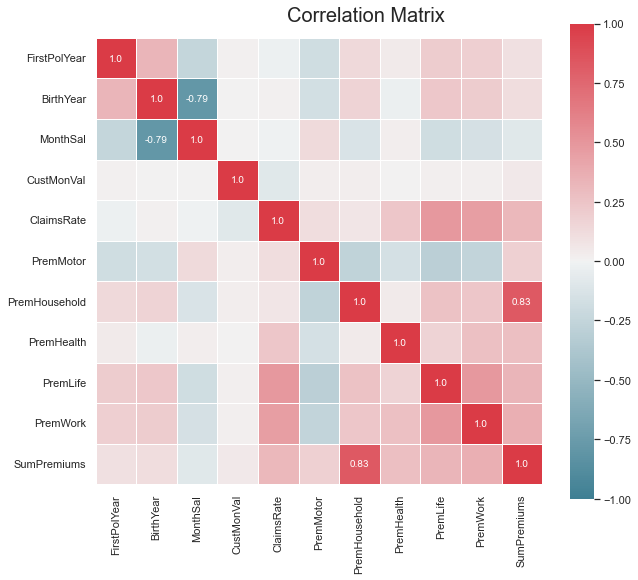

In [708]:
%matplotlib inline
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(file[metric_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

#plt.savefig(os.path.join('..', 'figures', 'correlation_matrix.png'), dpi=200)

plt.show()

## Outliers

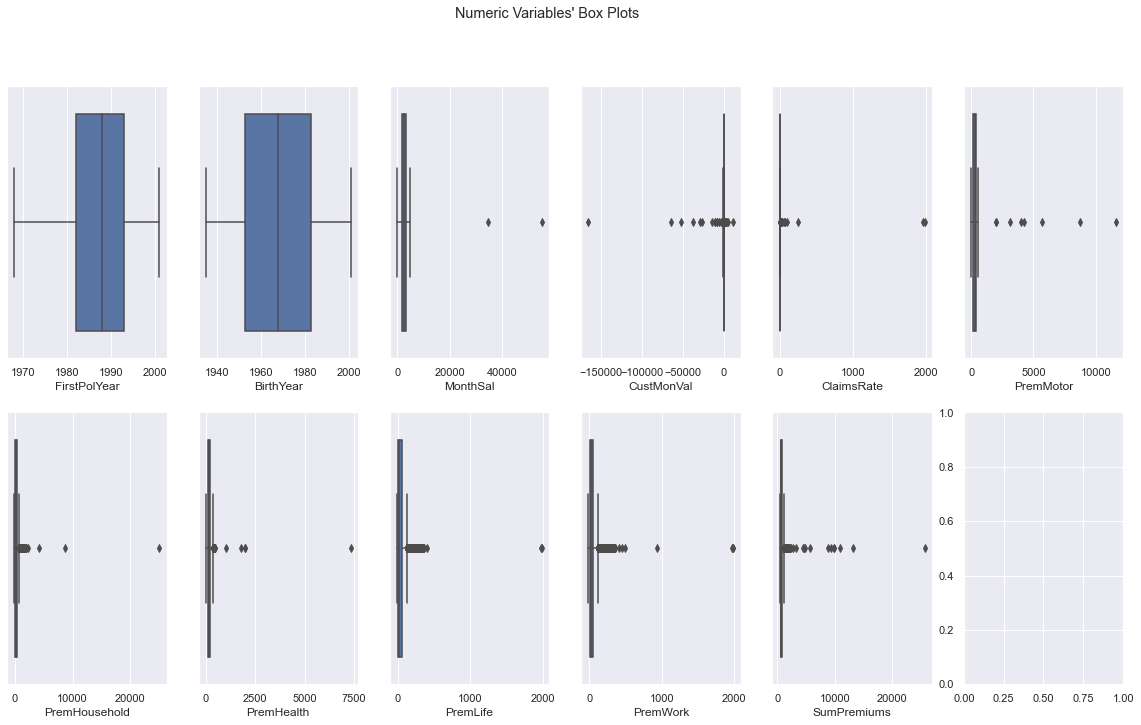

In [710]:
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=file[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()



In [711]:
#1st method for outlier detection 
filters1 = (
    (file['MonthSal']<=10000)
    &
    (file['CustMonVal']>=-2000)
    &
    (file['CustMonVal']<=1500)
    &
    (file['PremMotor']<=3000)
    &
    (file['PremHousehold']<=1250)
    &
    (file['PremHealth']<=2000)
    &
    (file['PremLife']<=300)
    &
    (file['PremWork']<= 400)
    &
    (file['SumPremiums']<= 1500)
    &
    (file['ClaimsRate']<= 4)
    
)

file_1 = file[filters1]
print('Percentage of data kept after removing outliers:', np.round(file_1.shape[0] / file.shape[0], 4))
file_1

Percentage of data kept after removing outliers: 0.9894


,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg,GeoLivArea,Children,SumPremiums
0,1985,1982,2177.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89,b'2 - High School',1,1,665.56
1,1995,1995,677.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,b'2 - High School',4,1,910.96
2,1991,1970,2277.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02,b'1 - Basic',3,0,740.60
3,1990,1981,1099.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,b'3 - BSc/MSc',4,1,600.68
4,1986,1973,1763.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45,b'3 - BSc/MSc',4,1,629.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10290,1984,1949,3188.0,-0.11,0.96,393.74,49.45,173.81,9.78,14.78,b'4 - PhD',2,0,641.56
10291,1977,1952,2431.0,1405.60,0.00,133.58,1035.75,143.25,12.89,105.13,b'1 - Basic',3,0,1430.60
10292,1994,1976,2918.0,524.10,0.21,403.63,132.80,142.25,12.67,4.89,b'3 - BSc/MSc',1,1,696.24
10293,1981,1977,1971.0,250.05,0.65,188.59,211.15,198.37,63.90,112.91,b'1 - Basic',2,1,774.92


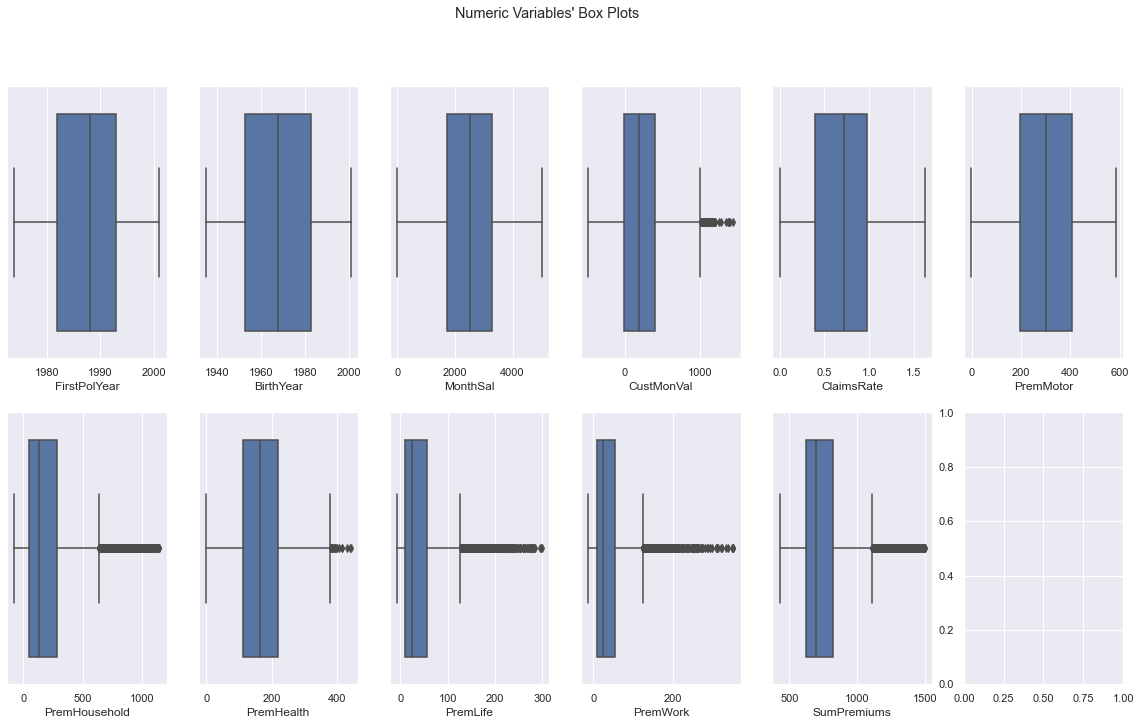

In [712]:
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=file_1[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()



In [713]:
q25 = file.quantile(.25)
q75 = file.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(file[metric].between(llim, ulim, inclusive=True))

filters2 = pd.Series(np.all(filters2, 0))

file_2 = file[filters2]
print('Percentage of data kept after removing outliers:', np.round(file_2.shape[0] / file.shape[0], 4))
file

Percentage of data kept after removing outliers: 0.8545


,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg,GeoLivArea,Children,SumPremiums
0,1985,1982,2177.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89,b'2 - High School',1,1,665.56
1,1995,1995,677.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,b'2 - High School',4,1,910.96
2,1991,1970,2277.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02,b'1 - Basic',3,0,740.60
3,1990,1981,1099.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,b'3 - BSc/MSc',4,1,600.68
4,1986,1973,1763.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45,b'3 - BSc/MSc',4,1,629.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10290,1984,1949,3188.0,-0.11,0.96,393.74,49.45,173.81,9.78,14.78,b'4 - PhD',2,0,641.56
10291,1977,1952,2431.0,1405.60,0.00,133.58,1035.75,143.25,12.89,105.13,b'1 - Basic',3,0,1430.60
10292,1994,1976,2918.0,524.10,0.21,403.63,132.80,142.25,12.67,4.89,b'3 - BSc/MSc',1,1,696.24
10293,1981,1977,1971.0,250.05,0.65,188.59,211.15,198.37,63.90,112.91,b'1 - Basic',2,1,774.92


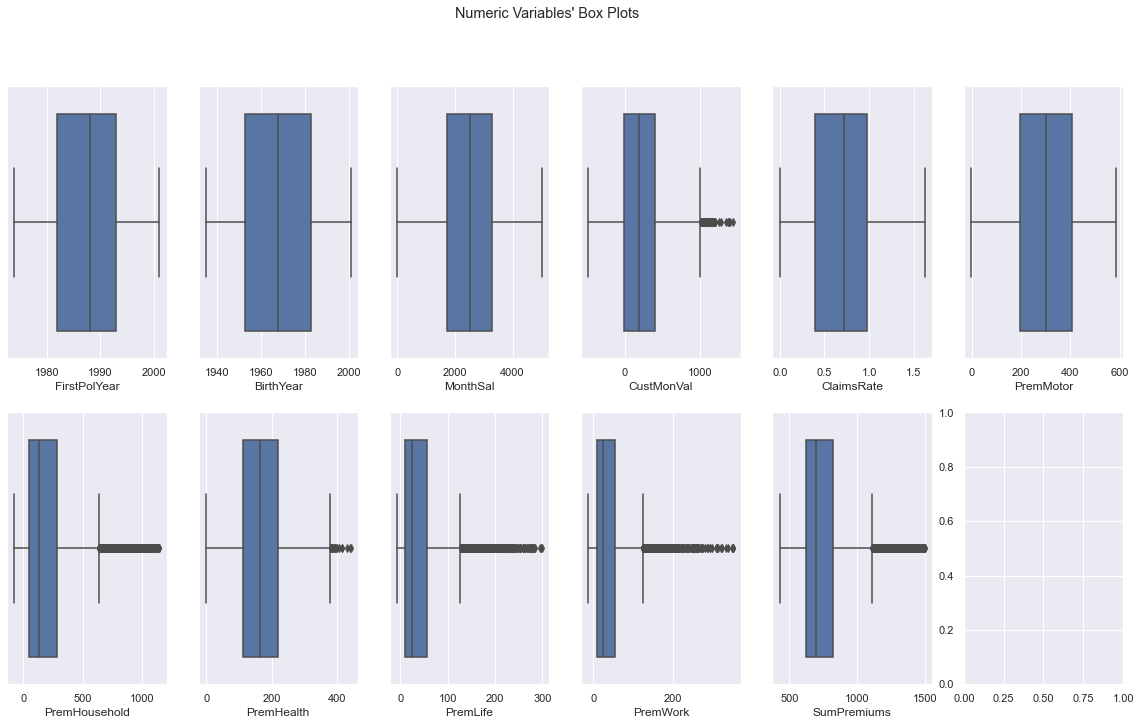

In [714]:
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=file_1[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

#plt.savefig(os.path.join('..', 'figures', 'numeric_variables_boxplots.png'), dpi=200)
plt.show()



In [716]:
file3 = file[(filters1 | filters2)]
print('Percentage of data kept after removing outliers:', np.round(file3.shape[0] / file.shape[0], 4))

Percentage of data kept after removing outliers: 0.9894


## Density Based Scan for outliers

In [717]:
scaler = StandardScaler()
fileDBscan=file.copy()
scaled_feat = scaler.fit_transform(fileDBscan[metric_features])
fileDBscan[metric_features]= scaled_feat
fileDBscan

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg,GeoLivArea,Children,SumPremiums
0,-0.396726,0.799663,-0.283475,0.104217,-0.026599,0.351763,-0.371495,-0.214219,0.091741,-0.423154,b'2 - High School',1,1,-0.247831
1,1.129486,1.547370,-1.578053,-0.158943,-0.000242,-1.049591,0.581401,-0.491746,2.798580,1.117139,b'2 - High School',4,1,0.367708
2,0.519001,0.109473,-0.197170,0.167784,-0.030571,-0.445213,0.038951,-0.417944,0.813834,0.994419,b'1 - Basic',3,0,-0.059608
3,0.366380,0.742148,-1.213845,-0.100289,-0.004936,-0.556377,-0.473646,1.327382,-0.122464,-0.225526,b'3 - BSc/MSc',4,1,-0.410570
4,-0.244105,0.282021,-0.640779,-0.073454,-0.008185,0.176917,-0.461054,0.124670,-0.426426,0.000754,b'3 - BSc/MSc',4,1,-0.338933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10290,-0.549347,-1.098360,0.589070,-0.091614,-0.006019,0.435781,-0.456385,0.042543,-0.591623,-0.459573,b'4 - PhD',2,0,-0.308031
10291,-1.617696,-0.925813,-0.064260,0.630758,-0.040680,-0.786030,2.334530,-0.243309,-0.534538,1.099879,b'1 - Basic',3,0,1.671124
10292,0.976865,0.454568,0.356046,0.177769,-0.033098,0.482229,-0.220531,-0.252663,-0.538576,-0.630276,b'3 - BSc/MSc',1,1,-0.170876
10293,-1.007211,0.512084,-0.461264,0.036939,-0.017212,-0.527682,0.001174,0.272273,0.401760,1.234162,b'1 - Basic',2,1,0.026477


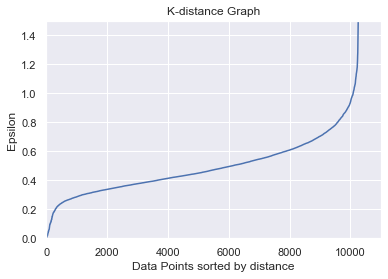

In [718]:
#Calculate the average distance between each point of the dataset and its 20 neighbors(minPTs)
neighbors = NearestNeighbors(n_neighbors=22) # n  neighbors = 2* number of features
neighbors_fit = neighbors.fit(fileDBscan[metric_features])
distances, indices = neighbors_fit.kneighbors(fileDBscan[metric_features])
#Sort distance values by ascending value and plot
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.axis([0, 11000, 0, 6])
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.show()


In [719]:
model=DBSCAN(eps = 0.8, min_samples =22, n_jobs=-1 ).fit(fileDBscan[metric_features])
labels = model.labels_
labels_df =  pd.DataFrame(labels, columns=['cluster'])
labels_df['cluster'].value_counts()

 0    7386
-1    2835
 1      74
Name: cluster, dtype: int64

In [720]:
print (labels_df[model.labels_ == -1])

       cluster
1           -1
2           -1
7           -1
13          -1
16          -1
...        ...
10287       -1
10288       -1
10289       -1
10291       -1
10293       -1

[2835 rows x 1 columns]


### Feature Engineering

In [721]:
file = file_1.copy()

In [722]:
file['age'] = file['BirthYear']
file['age'] = 2016 - file['BirthYear']

In [723]:
file[file['PremWork']<0] 
#Unearned premiums appear as a liability on the insurer's balance sheet because
#they would be paid back upon cancellation of the policy.

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg,GeoLivArea,Children,SumPremiums,age
28,1995,1952,3639.0,264.17,0.50,301.28,18.90,258.05,-4.00,-0.11,b'3 - BSc/MSc',4,0,574.12,64
29,1980,1972,2660.0,2.00,0.96,524.21,25.00,54.90,7.00,-5.00,b'3 - BSc/MSc',3,0,606.11,44
30,1988,1975,2148.0,427.76,0.19,483.09,-15.00,92.24,3.89,-5.11,b'2 - High School',4,1,559.11,41
64,1982,1973,2294.0,-124.32,1.19,452.53,-45.55,104.91,17.78,-4.11,b'3 - BSc/MSc',3,0,525.56,43
65,1998,1941,3760.0,132.27,0.78,276.83,175.60,261.27,6.89,-6.11,b'3 - BSc/MSc',1,0,714.48,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10242,1988,1970,2278.0,500.55,0.19,569.55,60.00,37.45,-4.00,-12.00,b'4 - PhD',1,1,651.00,46
10247,1977,1967,2211.0,-10.32,0.97,484.87,18.90,82.57,-2.00,-0.22,b'2 - High School',4,1,584.12,49
10253,1994,1963,1940.0,516.44,0.08,529.99,14.45,41.12,3.00,-3.00,b'3 - BSc/MSc',1,1,585.56,53
10254,1980,1945,3948.0,-28.22,1.01,423.19,13.35,128.47,4.78,-4.00,b'3 - BSc/MSc',4,0,565.79,71


In [724]:
# created number of year as customer 
file['nYearsCustomer']= 2016-file_1['FirstPolYear']
file['YearSalary']=file['MonthSal']*12
file['SpendingRate']=(file['SumPremiums']/file['YearSalary'])

In [725]:
file['SpendingRate'].mask((file['SpendingRate'] == np.Inf), 0, inplace=True)


In [726]:
file.drop(columns=['FirstPolYear','BirthYear','MonthSal'], inplace = True)
metric_features.remove('FirstPolYear')
metric_features.remove('BirthYear')
metric_features.remove('MonthSal')
#removing custID for obvious reasons but should be done earlier or even reset 

metric_features.append('age')
metric_features.append('nYearsCustomer')
metric_features.append('YearSalary')
metric_features.append('SpendingRate')
print(metric_features)
print(non_metric_features)

['CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork', 'SumPremiums', 'age', 'nYearsCustomer', 'YearSalary', 'SpendingRate']
['EducDeg', 'GeoLivArea', 'Children']


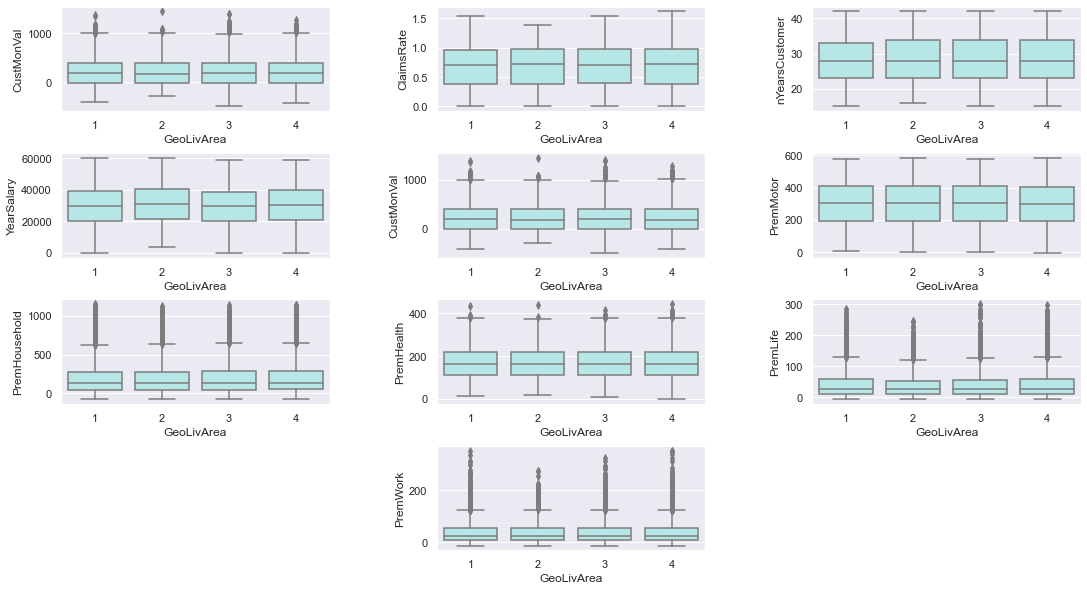

In [727]:
# we checked the true meaning of the feature "GeoLivArea " and found out that its unecessary to all of our dataset, it dosnt provide mucch information for us 
# so we decide to check the proportion of this feature to others 
fig = plt.figure(figsize=(2,5))
fig.set_size_inches(25,10)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

gs = fig.add_gridspec(nrows=4,ncols=4)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[1,2])
ax7 = fig.add_subplot(gs[2,0])
ax8 = fig.add_subplot(gs[2,1])
ax9 = fig.add_subplot(gs[2,2])
ax10 = fig.add_subplot(gs[3,1])


sns.boxplot(x="GeoLivArea", y="CustMonVal", data=file, ax=ax1, color='paleturquoise')
sns.boxplot(x="GeoLivArea", y="ClaimsRate", data=file, ax=ax2, color='paleturquoise')
sns.boxplot(x="GeoLivArea", y="nYearsCustomer", data=file, ax=ax3, color='paleturquoise')
sns.boxplot(x="GeoLivArea", y="YearSalary", data=file, ax=ax4, color='paleturquoise')
sns.boxplot(x="GeoLivArea", y="CustMonVal", data=file, ax=ax5, color='paleturquoise')
sns.boxplot(x="GeoLivArea", y="PremMotor", data=file, ax=ax6, color='paleturquoise')
sns.boxplot(x="GeoLivArea", y="PremHousehold", data=file, ax=ax7, color='paleturquoise')
sns.boxplot(x="GeoLivArea", y="PremHealth", data=file, ax=ax8, color='paleturquoise')
sns.boxplot(x="GeoLivArea", y="PremLife", data=file, ax=ax9, color='paleturquoise')
sns.boxplot(x="GeoLivArea", y="PremWork", data=file, ax=ax10, color='paleturquoise')
# as we can see ther is no significant difference for every features proportion on "area"
# so we decided to drop it 
file.drop('GeoLivArea',axis=1,inplace=True)
non_metric_features.remove('GeoLivArea')


### Data Normalization 

In [728]:
fileMinMax = file.copy()
fileMinMax

,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg,Children,SumPremiums,age,nYearsCustomer,YearSalary,SpendingRate
0,380.97,0.39,375.85,79.45,146.36,47.01,16.89,b'2 - High School',1,665.56,34,31,26124.0,0.025477
1,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,b'2 - High School',1,910.96,21,21,8124.0,0.112132
2,504.67,0.28,206.15,224.50,124.58,86.35,99.02,b'1 - Basic',0,740.60,46,25,27324.0,0.027104
3,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,b'3 - BSc/MSc',1,600.68,35,26,13188.0,0.045547
4,35.23,0.90,338.62,47.80,182.59,18.78,41.45,b'3 - BSc/MSc',1,629.24,43,30,21156.0,0.029743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10290,-0.11,0.96,393.74,49.45,173.81,9.78,14.78,b'4 - PhD',0,641.56,67,32,38256.0,0.016770
10291,1405.60,0.00,133.58,1035.75,143.25,12.89,105.13,b'1 - Basic',0,1430.60,64,39,29172.0,0.049040
10292,524.10,0.21,403.63,132.80,142.25,12.67,4.89,b'3 - BSc/MSc',1,696.24,40,22,35016.0,0.019883
10293,250.05,0.65,188.59,211.15,198.37,63.90,112.91,b'1 - Basic',1,774.92,39,35,23652.0,0.032763


In [729]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_feat = scaler.fit_transform(fileMinMax[metric_features])
scaled_feat


array([[-0.10118237, -0.51851852,  0.28946431, ...,  0.18518519,
        -0.13284206, -0.8604236 ],
       [-0.62953448,  0.38271605, -0.72317717, ..., -0.55555556,
        -0.7303326 , -0.38568116],
       [ 0.0264434 , -0.65432099, -0.28644393, ..., -0.25925926,
        -0.09300936, -0.85150772],
       ...,
       [ 0.04649003, -0.74074074,  0.38374086, ..., -0.48148148,
         0.16231826, -0.89106765],
       [-0.23625727, -0.19753086, -0.34603703, ...,  0.48148148,
        -0.21489743, -0.82050455],
       [-0.01577525, -0.66666667,  0.41920486, ..., -0.18518519,
         0.12129058, -0.89140888]])

In [730]:
fileMinMax[metric_features] = scaled_feat
fileMinMax.head()

,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg,Children,SumPremiums,age,nYearsCustomer,YearSalary,SpendingRate
0,-0.101182,-0.518519,0.289464,-0.747651,-0.332674,-0.647569,-0.841777,b'2 - High School',1,-0.558224,-0.424242,0.185185,-0.132842,-0.860424
1,-0.629534,0.382716,-0.723177,-0.197451,-0.466031,0.314715,-0.353031,b'2 - High School',1,-0.099571,-0.818182,-0.555556,-0.730333,-0.385681
2,0.026443,-0.654321,-0.286444,-0.510661,-0.430568,-0.390865,-0.391971,b'1 - Basic',0,-0.417974,-0.060606,-0.259259,-0.093009,-0.851508
3,-0.511772,0.222222,-0.366772,-0.806633,0.408095,-0.723719,-0.779068,b'3 - BSc/MSc',1,-0.679485,-0.393939,-0.185185,-0.562239,-0.750467
4,-0.457895,0.111111,0.163117,-0.799363,-0.169832,-0.831778,-0.707268,b'3 - BSc/MSc',1,-0.626106,-0.151515,0.111111,-0.297749,-0.837053


## Data Standardization


In [731]:
fileStandard = file.copy()

In [732]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(fileStandard[metric_features])
scaled_feat


array([[ 0.6574367 , -0.91139406,  0.56186046, ...,  0.38878629,
        -0.33543507, -0.24791347],
       [-1.38293837,  1.38272712, -1.61866647, ..., -1.1417761 ,
        -1.86275424,  2.83513093],
       [ 1.15029824, -1.25708355, -0.67824618, ..., -0.52955115,
        -0.2336138 , -0.19001247],
       ...,
       [ 1.22771376, -1.47706778,  0.76486672, ..., -0.98871986,
         0.41906059, -0.44692022],
       [ 0.1358083 , -0.0943098 , -0.80656835, ...,  1.00101124,
        -0.54518691,  0.01132649],
       [ 0.98725948, -1.28850987,  0.84123156, ..., -0.37649491,
         0.31418468, -0.44913625]])

In [733]:
fileStandard[metric_features] = scaled_feat
fileStandard.head()

,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg,Children,SumPremiums,age,nYearsCustomer,YearSalary,SpendingRate
0,0.657437,-0.911394,0.561860,-0.551195,-0.298027,0.129552,-0.511639,b'2 - High School',1,-0.468385,-0.814269,0.388786,-0.335435,-0.247913
1,-1.382938,1.382727,-1.618666,0.991617,-0.698603,3.341045,1.433693,b'2 - High School',1,0.916137,-1.566048,-1.141776,-1.862754,2.835131
2,1.150298,-1.257084,-0.678246,0.113348,-0.592079,0.986270,1.278703,b'1 - Basic',0,-0.045017,-0.120319,-0.529551,-0.233614,-0.190012
3,-0.928167,0.974185,-0.851218,-0.716586,1.927081,-0.124589,-0.262042,b'3 - BSc/MSc',1,-0.834431,-0.756440,-0.376495,-1.433068,0.466163
4,-0.720105,0.691348,0.289797,-0.696199,0.191116,-0.485220,0.023742,b'3 - BSc/MSc',1,-0.673298,-0.293807,0.235730,-0.756975,-0.096139


### Rouboust Scaler 

In [734]:
fileRouboust= file.copy()
scaler = RobustScaler()
scaled_feat = scaler.fit_transform(fileRouboust[metric_features])
scaled_feat

array([[ 0.47549907, -0.55932203,  0.35190136, ...,  0.27272727,
        -0.2130027 ,  0.13744911],
       [-0.78155051,  0.6779661 , -1.04164672, ..., -0.63636364,
        -1.16674615,  5.08931409],
       [ 0.77914491, -0.74576271, -0.44063562, ..., -0.27272727,
        -0.14941981,  0.23044743],
       ...,
       [ 0.82683964, -0.86440678,  0.48164018, ..., -0.54545455,
         0.25814656, -0.18218772],
       [ 0.15413033, -0.11864407, -0.52264475, ...,  0.63636364,
        -0.34398347,  0.55383017],
       [ 0.67869877, -0.76271186,  0.53044402, ..., -0.18181818,
         0.19265618, -0.18574702]])

In [735]:
fileRouboust[metric_features]=scaled_feat

In [736]:
fileRouboust

,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg,Children,SumPremiums,age,nYearsCustomer,YearSalary,SpendingRate
0,0.475499,-0.559322,0.351901,-0.223587,-0.154638,0.458626,-0.188889,b'2 - High School',1,-0.162273,-0.466667,0.272727,-0.213003,0.137449
1,-0.781551,0.677966,-1.041647,1.202414,-0.429870,3.595618,1.755338,b'2 - High School',1,1.099505,-0.900000,-0.636364,-1.166746,5.089314
2,0.779145,-0.745763,-0.440636,0.390642,-0.356679,1.295469,1.600436,b'1 - Basic',0,0.223562,-0.066667,-0.272727,-0.149420,0.230447
3,-0.501372,0.457627,-0.551180,-0.376456,1.374212,0.210381,0.060566,b'3 - BSc/MSc',1,-0.495867,-0.433333,-0.181818,-0.898426,1.284370
4,-0.373187,0.305085,0.178029,-0.357612,0.181447,-0.141885,0.346187,b'3 - BSc/MSc',1,-0.349020,-0.166667,0.181818,-0.476236,0.381223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10290,-0.459936,0.406780,0.435452,-0.350625,0.100000,-0.333333,-0.234858,b'4 - PhD',0,-0.285674,0.633333,0.363636,0.429820,-0.360096
10291,2.990654,-1.220339,-0.779554,3.825958,-0.183488,-0.267177,1.733551,b'1 - Basic',0,3.771348,0.533333,1.000000,-0.051502,1.483960
10292,0.826840,-0.864407,0.481640,0.002329,-0.192764,-0.271857,-0.450327,b'3 - BSc/MSc',1,-0.004525,-0.266667,-0.545455,0.258147,-0.182188
10293,0.154130,-0.118644,-0.522645,0.334110,0.327829,0.817911,1.903050,b'1 - Basic',1,0.400026,-0.300000,0.636364,-0.343983,0.553830


In [737]:
# defining the final dataset scaled
fileScale = fileStandard.copy()

## Label Encoding

In [738]:
file_encode = fileScale.copy()


In [739]:
label = preprocessing.LabelEncoder()
label=label.fit_transform(file_encode['EducDeg'])
file_encode['EducDeg']=label+1
file_encode['EducDeg']

0        2
1        2
2        1
3        3
4        3
        ..
10290    4
10291    1
10292    3
10293    1
10294    4
Name: EducDeg, Length: 10186, dtype: int32

In [740]:
# ProfileReport(
#     fileScale,
#     title='Data Preprocessed',
#     minimal = True,
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": False},
#         "kendall": {"calculate": False},
#         "phi_k": {"calculate": False},
#         "cramers": {"calculate": False},
#     },
# )

In [741]:
insurance_features=[
    'PremMotor',
    'PremHousehold',
    'PremHealth',
    'PremLife',
    'PremWork',
    'SumPremiums']
rates_features=[
    'CustMonVal',
    'ClaimsRate',
    'nYearsCustomer',
    'SpendingRate'
]
fileInsurance=file[insurance_features]
fileRates=file[rates_features]

In [742]:
demograph_features=[
    'age',
    'YearSalary',
    'Children',
    'EducDeg'
]
fileDemograph=file[demograph_features]
label = preprocessing.LabelEncoder()
label=label.fit_transform(fileDemograph['EducDeg'])
fileDemograph['EducDeg']=label+1


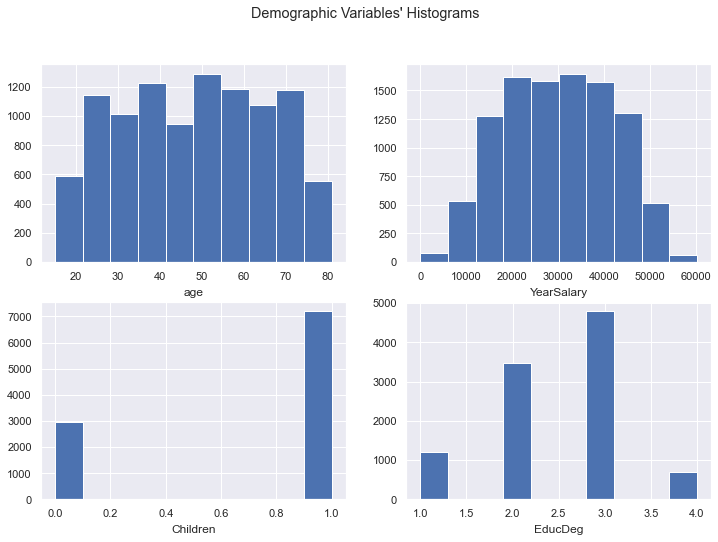

In [743]:
###  Distribution of our Socio Demographic features
sns.set()

fig, axes = plt.subplots(2, ceil(len(demograph_features) / 2), figsize=(12, 8))

for ax, feat in zip(axes.flatten(), demograph_features): #
    ax.hist(fileDemograph[feat])
    ax.set_title(feat, y=-0.2)
    

title = "Demographic Variables' Histograms"

plt.suptitle(title)

plt.show()

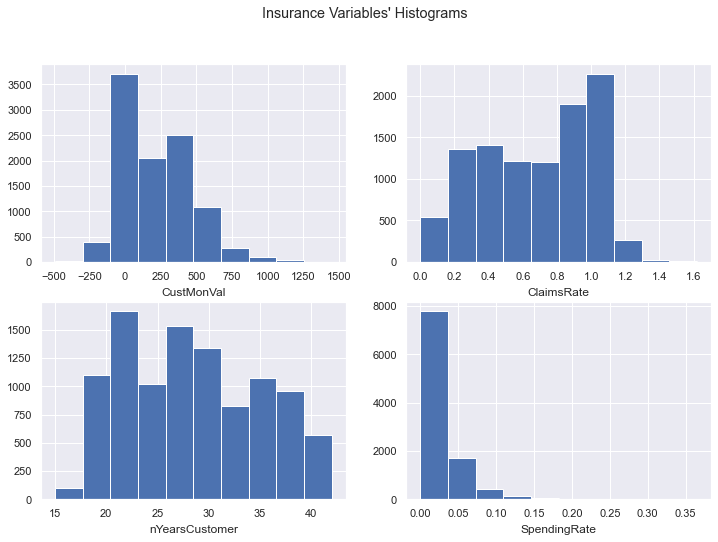

In [744]:
###  Distribution of our Ratios features
sns.set()

fig, axes = plt.subplots(2, ceil(len(rates_features) / 2), figsize=(12, 8))

for ax, feat in zip(axes.flatten(), rates_features): #
    ax.hist(fileRates[feat])
    ax.set_title(feat, y=-0.2)
    

title = "Insurance Variables' Histograms"

plt.suptitle(title)

plt.show()

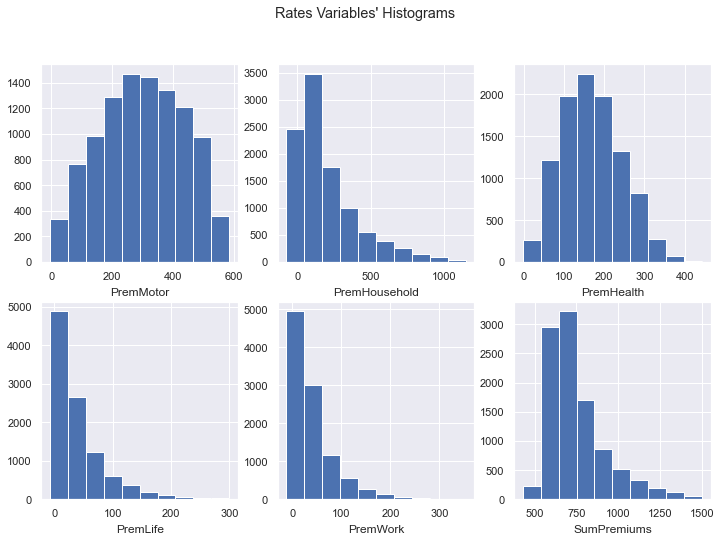

In [745]:
###  Distribution of our Insurance features
sns.set()

fig, axes = plt.subplots(2, ceil(len(insurance_features) / 2), figsize=(12, 8))

for ax, feat in zip(axes.flatten(), insurance_features): #
    ax.hist(fileInsurance[feat])
    ax.set_title(feat, y=-0.2)
    

title = "Rates Variables' Histograms"

plt.suptitle(title)

plt.show()

In [746]:
scaler=StandardScaler()
scaled_feat_1=scaler.fit_transform(fileInsurance)
fileInsurance_S=fileInsurance.copy()
fileInsurance_S[insurance_features]=scaled_feat_1

scaled_feat_2= scaler.fit_transform(fileRates)
fileRates_S=fileRates.copy()
fileRates_S[rates_features]=scaled_feat_2

scaled_feat_3=scaler.fit_transform(fileDemograph[['age','YearSalary']])
fileDemograph_S=fileDemograph.copy()
fileDemograph_S[['age','YearSalary']]=scaled_feat_3

## K-Means and K-prototypes 

#### Demographic View

In [747]:
fileDemographS_array=fileDemograph_S.to_numpy()


cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(fileDemographS_array, categorical =[2,3] )
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

In [748]:
df_cost = pd.DataFrame({'Cluster':range(1, 10), 'Cost':cost})
df_cost.head()

,Cluster,Cost
0,1,24554.500000
1,2,10020.020967
2,3,6643.045633
3,4,5375.234288
4,5,4776.624948


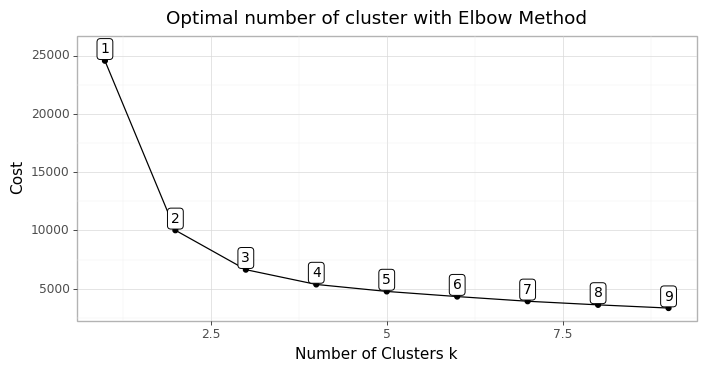

<ggplot: (145229242173)>

In [749]:
plotnine.options.figure_size = (8, 3.7)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_light()
)

#### Insurance View

In [750]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
kmeans_Ins = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)
kmeans_Ins.fit_predict(fileInsurance_S)

array([3, 6, 6, ..., 3, 2, 3])

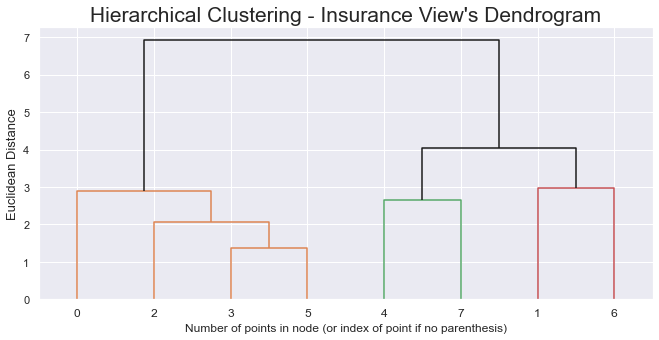

In [751]:

distance = 'Euclidean'
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
cen = kmeans_Ins.cluster_centers_

Z = linkage(cen, method = 'ward') 
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 3.1
dendrogram(Z, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(100, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - Insurance View\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

#### Rates View

In [752]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
kmeans_Rates = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)
kmeans_Rates.fit_predict(fileRates_S)

array([2, 4, 5, ..., 5, 2, 5])

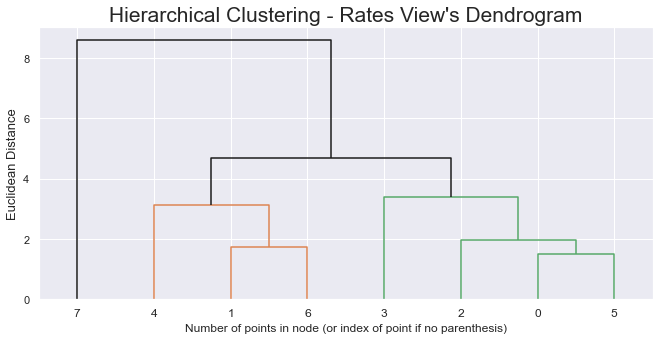

In [753]:
distance = 'Euclidean'
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
cen = kmeans_Rates.cluster_centers_

Z = linkage(cen, method = 'ward') 
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 4
dendrogram(Z, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(100, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - Rates View\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

## K-means/ K-prototypes Labels

In [754]:
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kproto_labels = kprototype.fit_predict(fileDemographS_array, categorical = [2,3])


fileDemograph['kproto_labels'] = kproto_labels
file_encode['kproto_labels'] = kproto_labels
file['kproto_labels'] = kproto_labels




In [755]:
kmeans_insurance = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
kmeans_labels_insurance = kmeans_insurance.fit_predict(fileInsurance_S)

fileInsurance['kmeans_labels'] = kmeans_labels_insurance
file_encode['kmeans_labels_ins'] = kmeans_labels_insurance
file['kmeans_labels_ins'] = kmeans_labels_insurance





In [756]:
kmeans_rates = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
kmeans_labels_rates = kmeans_rates.fit_predict(fileRates_S)

fileRates['kmeans_labels'] = kmeans_labels_rates
file_encode['kmeans_labels_rates'] = kmeans_labels_rates
file['kmeans_labels_rates'] = kmeans_labels_rates





## K-means/ K-prototypes Visualization

#### Demographic

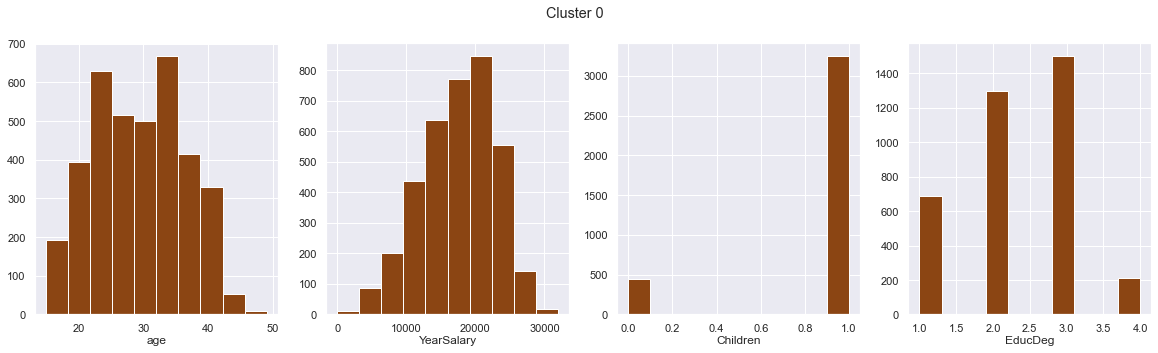

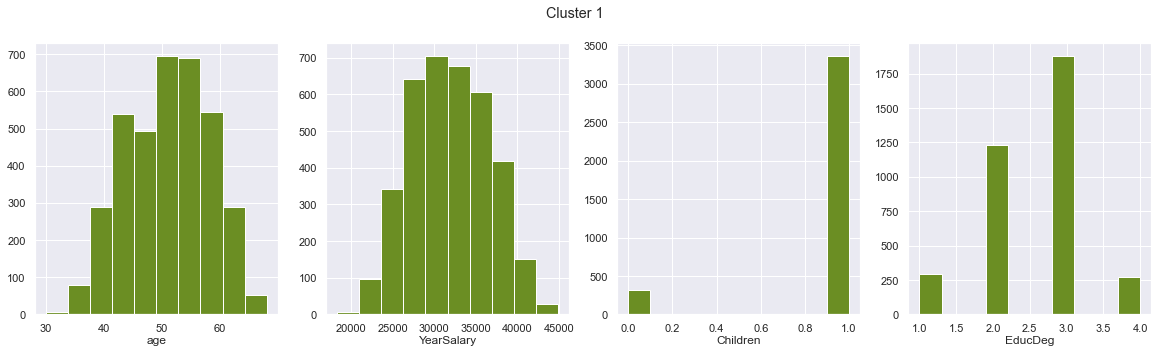

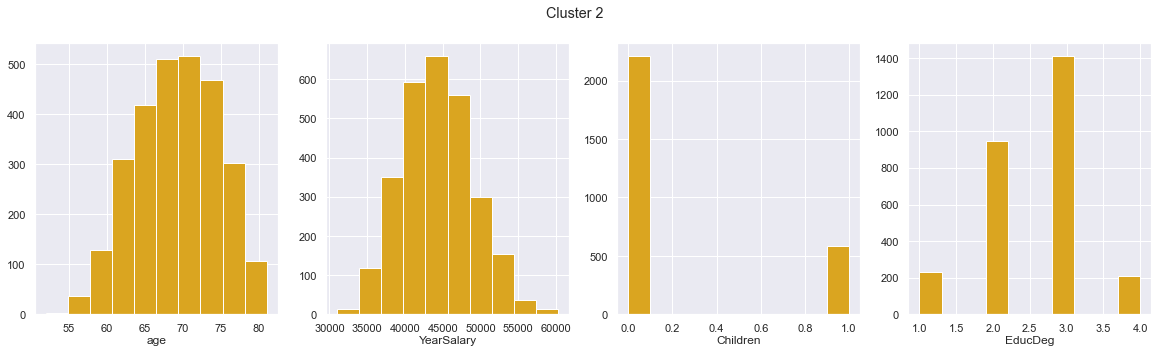

In [757]:
features = fileDemograph.iloc[:, 0: 4].columns.to_list()

#cluster 0 
som_df_0 = fileDemograph[fileDemograph['kproto_labels'] == 0]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(som_df_0[feat], color='saddlebrown')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 0'
plt.suptitle(title)

som_df_1 = fileDemograph[fileDemograph['kproto_labels'] == 1]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(som_df_1[feat], color='olivedrab')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 1'
plt.suptitle(title)

som_df_2 = fileDemograph[fileDemograph['kproto_labels'] == 2]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(som_df_2[feat], color='goldenrod')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 2'
plt.suptitle(title)
plt.show()


#### Insurance

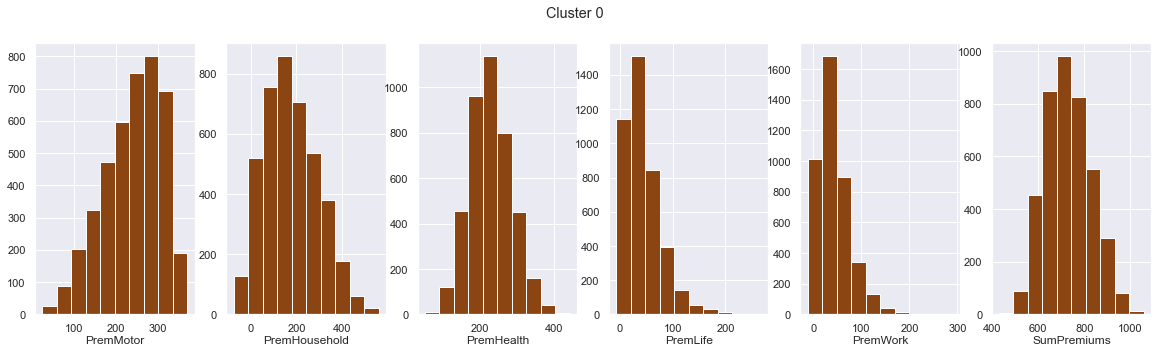

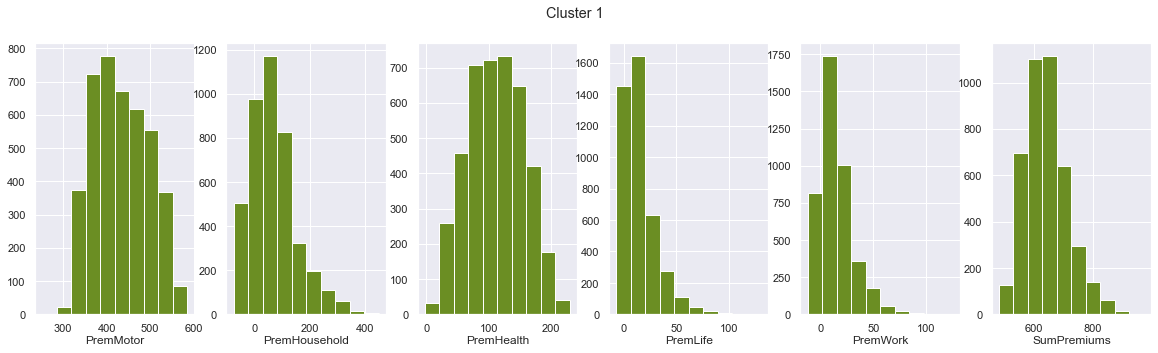

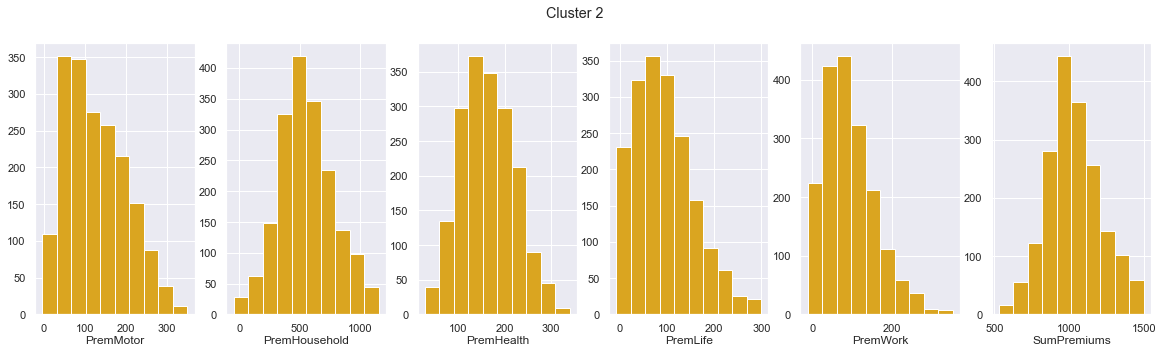

In [758]:
features = fileInsurance.iloc[:, 0: 6].columns.to_list()

#cluster 0 
som_df_0 = fileInsurance[fileInsurance['kmeans_labels'] == 0]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(som_df_0[feat], color='saddlebrown')
    ax.set_title(feat, y=-0.13)
# Layout
# Add a centered title to the figure:
title = 'Cluster 0'
plt.suptitle(title)

som_df_1 = fileInsurance[fileInsurance['kmeans_labels'] == 1]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(som_df_1[feat], color='olivedrab')
    ax.set_title(feat, y=-0.13)
# Layout
# Add a centered title to the figure:
title = 'Cluster 1'
plt.suptitle(title)

som_df_2 = fileInsurance[fileInsurance['kmeans_labels'] == 2]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(som_df_2[feat], color='goldenrod')
    ax.set_title(feat, y=-0.13)

            
# Layout
# Add a centered title to the figure:
title = 'Cluster 2'
plt.suptitle(title)
plt.show()


#### Rates

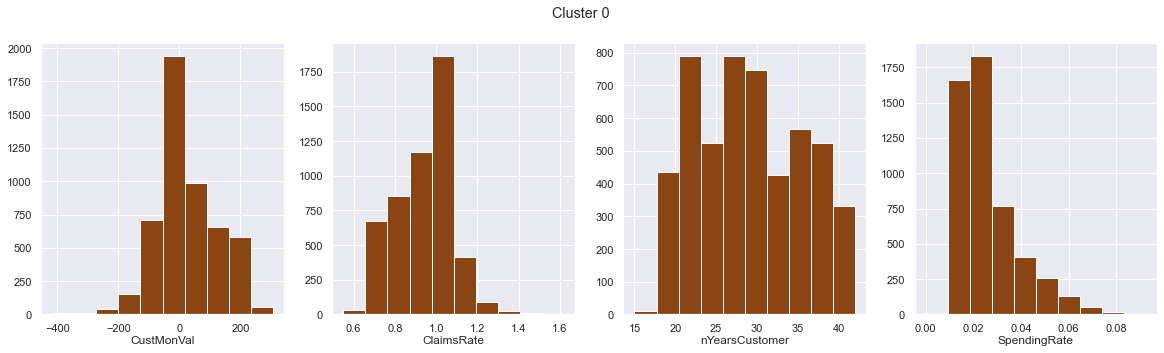

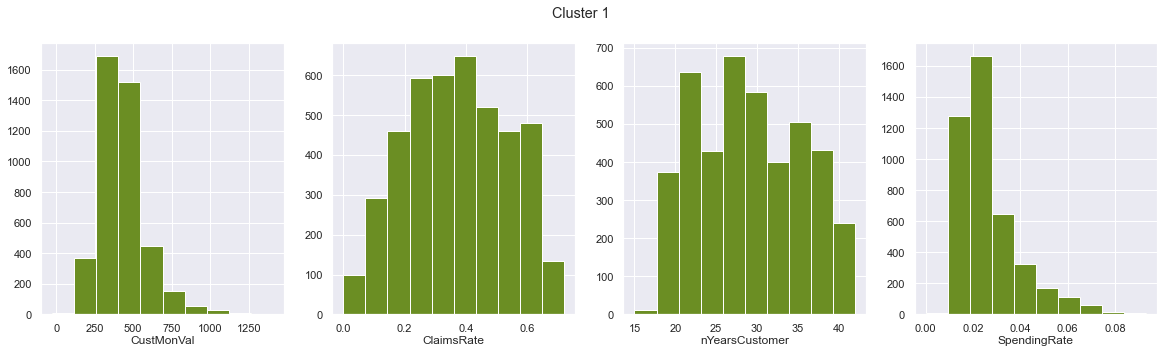

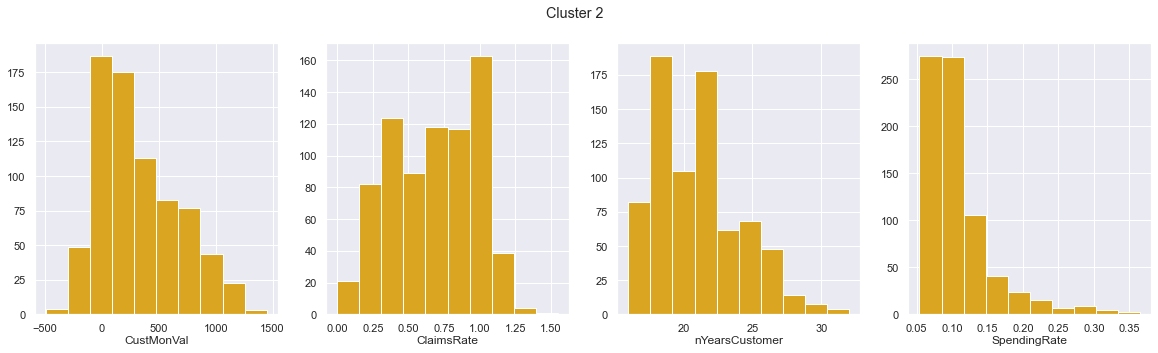

In [759]:
features = fileRates.iloc[:, 0: 4].columns.to_list()

#cluster 0 
som_df_0 = fileRates[fileRates['kmeans_labels'] == 0]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(som_df_0[feat], color='saddlebrown')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 0'
plt.suptitle(title)

som_df_1 = fileRates[fileRates['kmeans_labels'] == 1]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(som_df_1[feat], color='olivedrab')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 1'
plt.suptitle(title)

som_df_2 = fileRates[fileRates['kmeans_labels'] == 2]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(som_df_2[feat], color='goldenrod')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 2'
plt.suptitle(title)
plt.show()


## SOM 

In [760]:
np.random.seed(42)

# Notice that the SOM did not converge - We're under a time constraint for this class
sm_Ins = sompy.SOMFactory().build(
   fileInsurance_S.values, 
    mapsize=[50, 50],  # NEEDS TO BE A LIST
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=insurance_features
)
sm_Ins.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

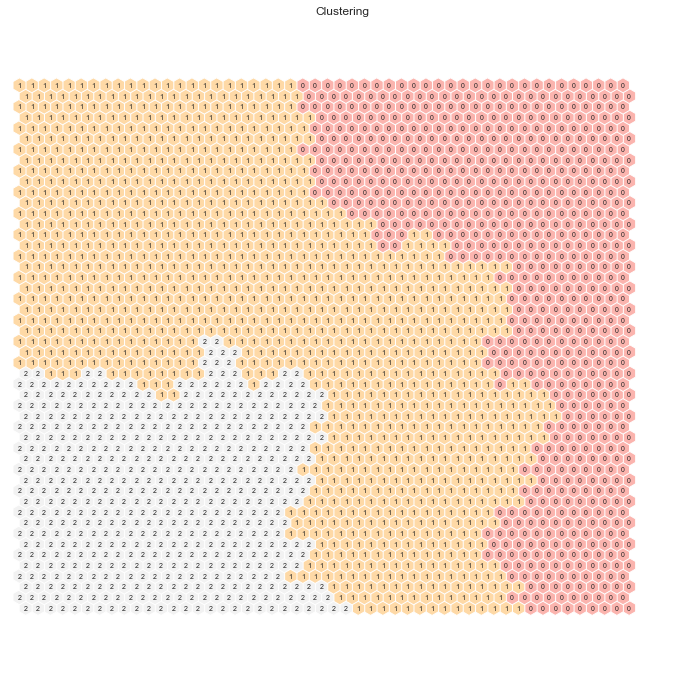

In [761]:
hierclust_Ins = AgglomerativeClustering(n_clusters=3, linkage='ward')
nodeclus_labels_Ins = hierclust_Ins.fit_predict(sm_Ins.codebook.matrix)
sm_Ins.cluster_labels = nodeclus_labels_Ins  # setting the cluster labels of sompy

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm_Ins, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [762]:
nodes_ins = sm_Ins.codebook.matrix

df_nodes_ins = pd.DataFrame(nodes_ins, columns=insurance_features)
df_nodes_ins['label'] = nodeclus_labels_Ins
#fileInsurance['SOM_labels'] = nodeclus_labels_Ins



In [763]:
bmus_map_ins = sm_Ins.find_bmu(fileInsurance_S)[0]  # get bmus for each observation in df

df_bmus_ins = pd.DataFrame(
    np.concatenate((fileInsurance_S, np.expand_dims(bmus_map_ins,1)), axis=1),
    index=fileInsurance_S.index, columns=np.append(fileInsurance_S.columns,"BMU")
)


### SOM Labels for Insurance view

In [764]:
df_SOM_ins = df_bmus_ins.merge(df_nodes_ins['label'], 'left', left_on="BMU", right_index=True)


#### Rates View

In [765]:
sm_Rates = sompy.SOMFactory().build(
    fileRates_S.values, 
    mapsize=[50, 50],  # NEEDS TO BE A LIST
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names= rates_features
)
sm_Rates.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

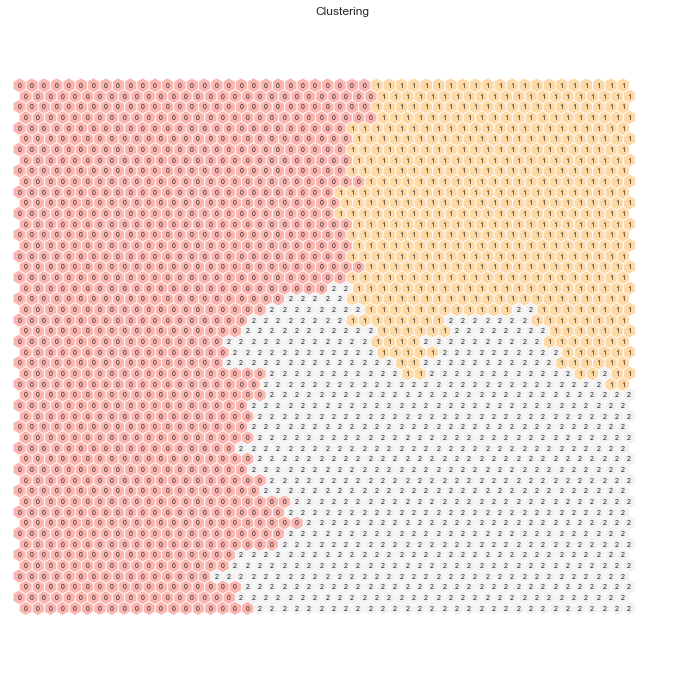

In [766]:
hierclust_Rates = AgglomerativeClustering(n_clusters=3, linkage='ward')
nodeclus_labels_Rates = hierclust_Rates.fit_predict(sm_Rates.codebook.matrix)
sm_Rates.cluster_labels = nodeclus_labels_Rates  # setting the cluster labels of sompy

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm_Rates, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [767]:
nodes_rates = sm_Rates.codebook.matrix

df_nodes_rates = pd.DataFrame(nodes_rates, columns=rates_features)
df_nodes_rates['label'] = nodeclus_labels_Rates
#fileRates['SOM_labels'] = nodeclus_labels_Rates


In [768]:
bmus_map_rates = sm_Rates.find_bmu(fileRates_S)[0]  # get bmus for each observation in df

df_bmus_rates = pd.DataFrame(
    np.concatenate((fileRates_S, np.expand_dims(bmus_map_ins,1)), axis=1),
    index=fileRates_S.index, columns=np.append(fileRates_S.columns,"BMU")
)



### SOM Labels for Rates view

In [769]:
df_SOM_rates = df_bmus_rates.merge(df_nodes_rates['label'], 'left', left_on="BMU", right_index=True)
df_SOM_rates

,CustMonVal,ClaimsRate,nYearsCustomer,SpendingRate,BMU,label
0,0.657437,-0.911394,0.388786,-0.247913,1233.0,0
1,-1.382938,1.382727,-1.141776,2.835131,2419.0,1
2,1.150298,-1.257084,-0.529551,-0.190012,1669.0,1
3,-0.928167,0.974185,-0.376495,0.466163,2249.0,0
4,-0.720105,0.691348,0.235730,-0.096139,1174.0,2
...,...,...,...,...,...,...
10290,-0.860912,0.879906,0.541843,-0.557686,1243.0,0
10291,4.739900,-2.137020,1.613236,0.590428,1900.0,1
10292,1.227714,-1.477068,-0.988720,-0.446920,425.0,2
10293,0.135808,-0.094310,1.001011,0.011326,1668.0,1


In [770]:
fileInsurance['SOM_labels'] = df_SOM_ins['label']
fileRates['SOM_labels'] = df_SOM_rates['label']

## SOM Visualization

#### Insurance 


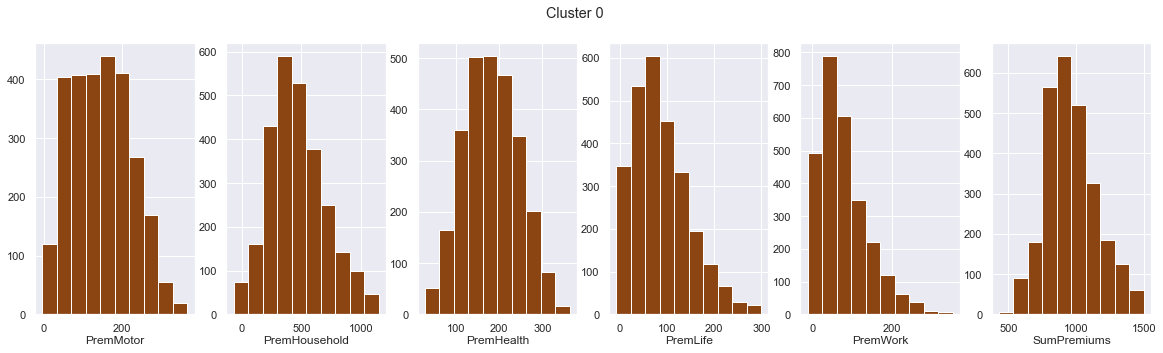

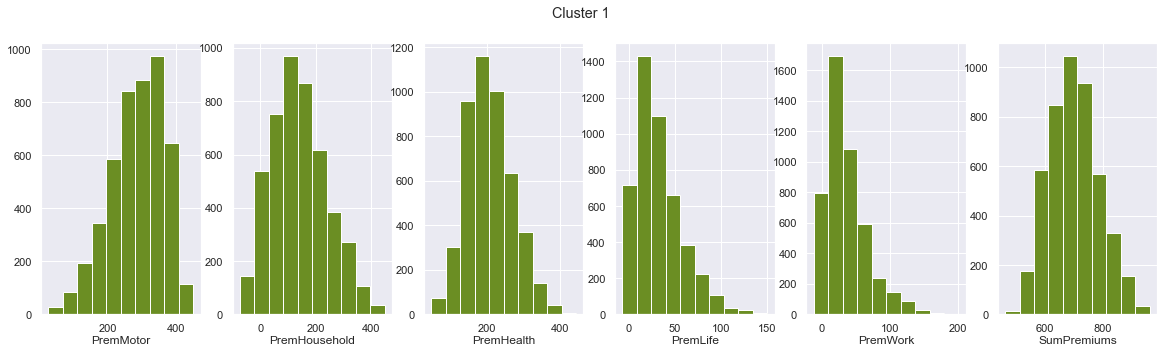

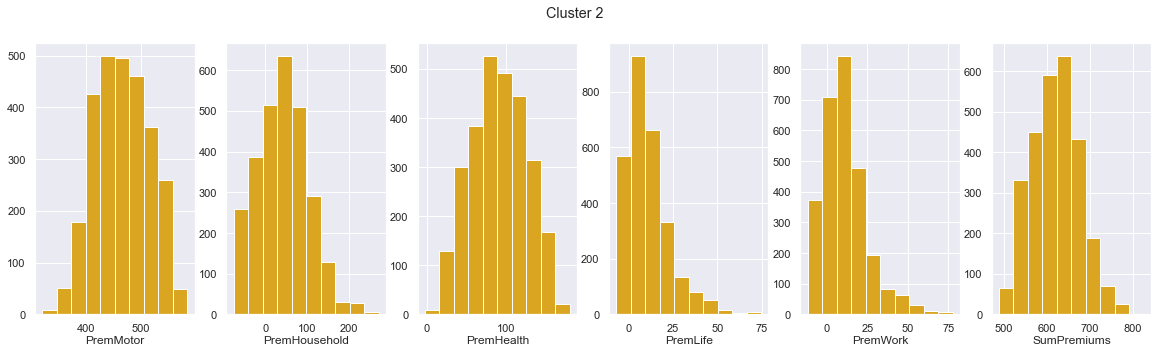

In [771]:
features = fileInsurance.iloc[:, 0: 6].columns.to_list()

#cluster 0 
som_df_0 = fileInsurance[fileInsurance['SOM_labels'] == 0]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(som_df_0[feat], color='saddlebrown')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 0'
plt.suptitle(title)

som_df_1 = fileInsurance[fileInsurance['SOM_labels'] == 1]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(som_df_1[feat], color='olivedrab')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 1'
plt.suptitle(title)

som_df_2 = fileInsurance[fileInsurance['SOM_labels'] == 2]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(som_df_2[feat], color='goldenrod')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 2'
plt.suptitle(title)
plt.show()


#### Rates

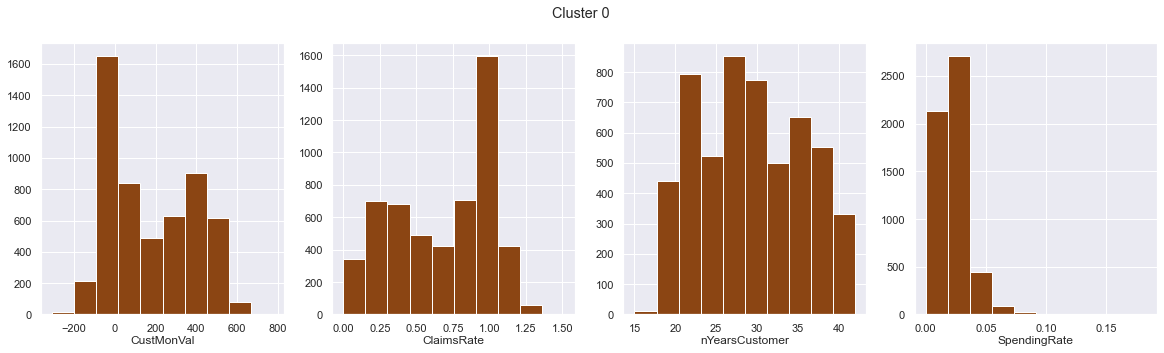

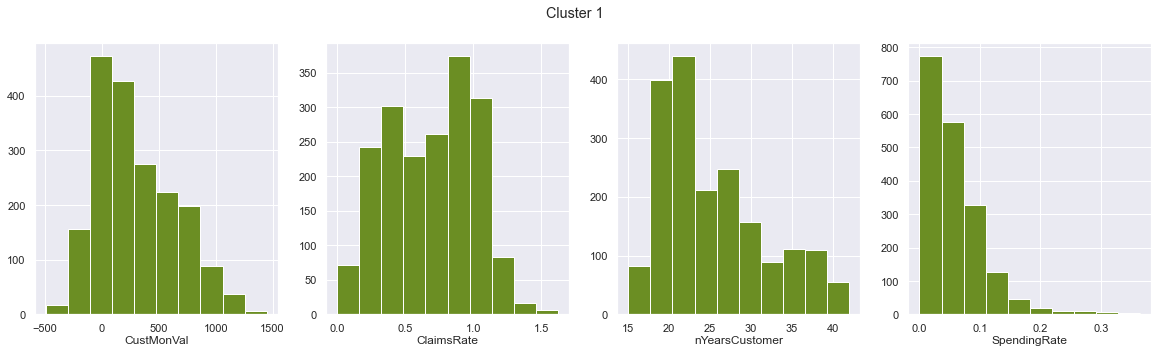

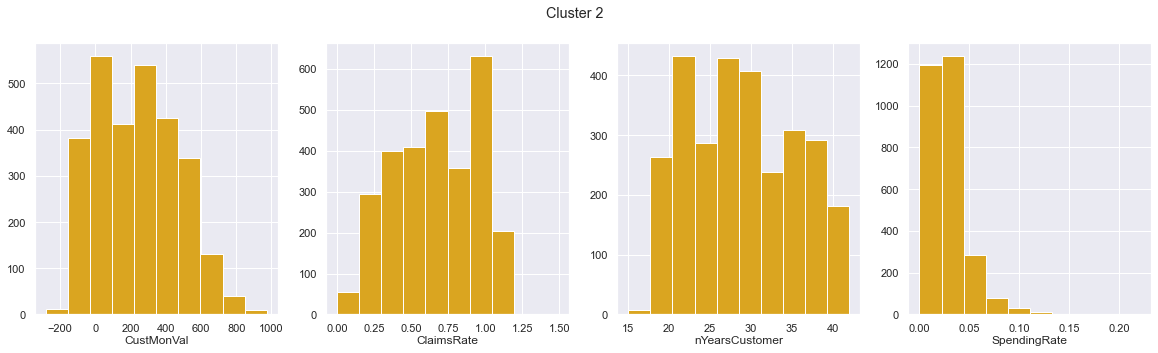

In [772]:
features = fileRates.iloc[:, 0: 4].columns.to_list()

#cluster 0 
som_df_0 = fileRates[fileRates['SOM_labels'] == 0]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(som_df_0[feat], color='saddlebrown')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 0'
plt.suptitle(title)

som_df_1 = fileRates[fileRates['SOM_labels'] == 1]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(som_df_1[feat], color='olivedrab')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 1'
plt.suptitle(title)

som_df_2 = fileRates[fileRates['SOM_labels'] == 2]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(som_df_2[feat], color='goldenrod')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 2'
plt.suptitle(title)
plt.show()


## Density Based Scan for clustering

#### Insurance View

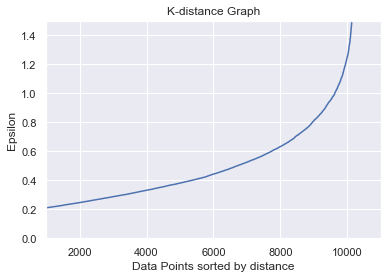

In [773]:
neigh = NearestNeighbors(n_neighbors=12)
neigh.fit(fileInsurance_S)
distances, _ = neigh.kneighbors(fileInsurance_S)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.axis([1000, 11000, 0, 1.5])
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.show()

In [774]:
dbscan = DBSCAN(eps=0.9, min_samples=12, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(fileInsurance_S)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 5


In [775]:
# Concatenating the labels to df
insurDbscan = pd.concat([fileInsurance_S, pd.Series(dbscan_labels, index=fileInsurance.index, name="dbscan_labels")], axis=1)
insurDbscan

,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,SumPremiums,dbscan_labels
0,0.561860,-0.551195,-0.298027,0.129552,-0.511639,-0.468385,0
1,-1.618666,0.991617,-0.698603,3.341045,1.433693,0.916137,0
2,-0.678246,0.113348,-0.592079,0.986270,1.278703,-0.045017,0
3,-0.851218,-0.716586,1.927081,-0.124589,-0.262042,-0.834431,0
4,0.289797,-0.696199,0.191116,-0.485220,0.023742,-0.673298,0
...,...,...,...,...,...,...,...
10290,0.692594,-0.688639,0.072577,-0.681215,-0.557635,-0.603790,0
10291,-1.208562,3.830070,-0.340015,-0.613488,1.411895,3.847892,-1
10292,0.764867,-0.306773,-0.353516,-0.618279,-0.773226,-0.295291,0
10293,-0.806568,0.052186,0.404163,0.497370,1.581490,0.148613,0


In [776]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable
# Computing the R^2 of the cluster solution
df_nonoise = insurDbscan.loc[insurDbscan['dbscan_labels'] != -1]
sst = get_ss(fileInsurance_S)  # get total sum of squares
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.1999


In [777]:
db_insurance= fileInsurance.copy()
db_insurance['Cluster_label']=insurDbscan['dbscan_labels']
print(db_insurance['Cluster_label'].value_counts())


 0    9765
-1     384
 1      14
 2      12
 3      11
Name: Cluster_label, dtype: int64


#### Rates View

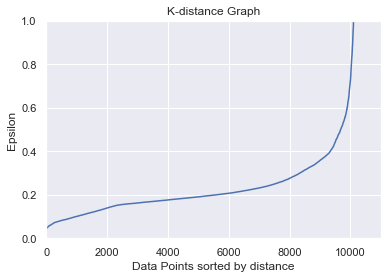

In [778]:
neigh = NearestNeighbors(n_neighbors=8)
neigh.fit(fileRates_S)
distances, _ = neigh.kneighbors(fileRates_S)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.axis([0, 11000, 0, 1])
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.show()

In [779]:
dbscan = DBSCAN(eps=0.4, min_samples=8, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(fileRates_S)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 4


In [780]:
# Concatenating the labels to df
rateDbscan = pd.concat([fileRates_S, pd.Series(dbscan_labels, index=fileRates.index, name="dbscan_labels")], axis=1)
rateDbscan

,CustMonVal,ClaimsRate,nYearsCustomer,SpendingRate,dbscan_labels
0,0.657437,-0.911394,0.388786,-0.247913,0
1,-1.382938,1.382727,-1.141776,2.835131,0
2,1.150298,-1.257084,-0.529551,-0.190012,0
3,-0.928167,0.974185,-0.376495,0.466163,0
4,-0.720105,0.691348,0.235730,-0.096139,0
...,...,...,...,...,...
10290,-0.860912,0.879906,0.541843,-0.557686,0
10291,4.739900,-2.137020,1.613236,0.590428,-1
10292,1.227714,-1.477068,-0.988720,-0.446920,0
10293,0.135808,-0.094310,1.001011,0.011326,0


In [781]:
# Computing the R^2 of the cluster solution
df_nonoise = rateDbscan.loc[rateDbscan['dbscan_labels'] != -1]
sst = get_ss(fileRates_S)  # get total sum of squares
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.2731


In [782]:
db_rates= fileRates.copy()
db_rates['Cluster_label']=rateDbscan['dbscan_labels']
print(db_rates['Cluster_label'].value_counts())
db_rates

 0    9618
-1     529
 1      29
 2      10
Name: Cluster_label, dtype: int64


,CustMonVal,ClaimsRate,nYearsCustomer,SpendingRate,kmeans_labels,SOM_labels,Cluster_label
0,380.97,0.39,31,0.025477,1,0,0
1,-131.13,1.12,21,0.112132,2,1,0
2,504.67,0.28,25,0.027104,1,1,0
3,-16.99,0.99,26,0.045547,0,0,0
4,35.23,0.90,30,0.029743,0,2,0
...,...,...,...,...,...,...,...
10290,-0.11,0.96,32,0.016770,0,0,0
10291,1405.60,0.00,39,0.049040,1,1,-1
10292,524.10,0.21,22,0.019883,1,2,0
10293,250.05,0.65,35,0.032763,1,1,0


In [783]:
fileInsurance['DBSCAN_labels'] = db_insurance['Cluster_label']
fileRates['DBSCAN_labels'] = db_rates['Cluster_label']


## Merge using hierarchical clustering


In [784]:
file_encode.rename({'kproto_labels':'Demographic_labels'}, axis = 1, inplace = True)

In [785]:
file_encode.rename({'kmeans_labels_ins':'Insurance_labels'}, axis = 1, inplace = True)

In [786]:
file_encode['Rate_labels'] = df_SOM_rates['label']

In [787]:
file_encode.drop(['kmeans_labels_rates'], axis = 1, inplace = True )

In [788]:
file_encode

,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg,Children,SumPremiums,age,nYearsCustomer,YearSalary,SpendingRate,Demographic_labels,Insurance_labels,Rate_labels
0,0.657437,-0.911394,0.561860,-0.551195,-0.298027,0.129552,-0.511639,2,1,-0.468385,-0.814269,0.388786,-0.335435,-0.247913,0,1,0
1,-1.382938,1.382727,-1.618666,0.991617,-0.698603,3.341045,1.433693,2,1,0.916137,-1.566048,-1.141776,-1.862754,2.835131,0,2,1
2,1.150298,-1.257084,-0.678246,0.113348,-0.592079,0.986270,1.278703,1,0,-0.045017,-0.120319,-0.529551,-0.233614,-0.190012,1,0,1
3,-0.928167,0.974185,-0.851218,-0.716586,1.927081,-0.124589,-0.262042,3,1,-0.834431,-0.756440,-0.376495,-1.433068,0.466163,0,0,0
4,-0.720105,0.691348,0.289797,-0.696199,0.191116,-0.485220,0.023742,3,1,-0.673298,-0.293807,0.235730,-0.756975,-0.096139,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10290,-0.860912,0.879906,0.692594,-0.688639,0.072577,-0.681215,-0.557635,4,0,-0.603790,1.094093,0.541843,0.693978,-0.557686,2,1,0
10291,4.739900,-2.137020,-1.208562,3.830070,-0.340015,-0.613488,1.411895,1,0,3.847892,0.920605,1.613236,-0.076809,0.590428,1,2,1
10292,1.227714,-1.477068,0.764867,-0.306773,-0.353516,-0.618279,-0.773226,3,1,-0.295291,-0.467294,-0.988720,0.419061,-0.446920,1,1,2
10293,0.135808,-0.094310,-0.806568,0.052186,0.404163,0.497370,1.581490,1,1,0.148613,-0.525123,1.001011,-0.545187,0.011326,0,0,1


#### Merging Using Hierarchical 

In [789]:
df_centroids = file_encode.groupby(['Demographic_labels', 'Insurance_labels','Rate_labels'])\
    [metric_features].mean()


In [790]:
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

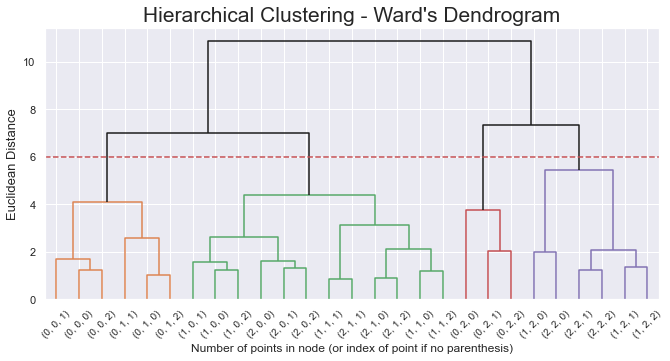

In [791]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 6
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - Ward\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [792]:
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=4
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels


In [793]:
file

,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,EducDeg,Children,SumPremiums,age,nYearsCustomer,YearSalary,SpendingRate,kproto_labels,kmeans_labels_ins,kmeans_labels_rates
0,380.97,0.39,375.85,79.45,146.36,47.01,16.89,b'2 - High School',1,665.56,34,31,26124.0,0.025477,0,1,1
1,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,b'2 - High School',1,910.96,21,21,8124.0,0.112132,0,2,2
2,504.67,0.28,206.15,224.50,124.58,86.35,99.02,b'1 - Basic',0,740.60,46,25,27324.0,0.027104,1,0,1
3,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,b'3 - BSc/MSc',1,600.68,35,26,13188.0,0.045547,0,0,0
4,35.23,0.90,338.62,47.80,182.59,18.78,41.45,b'3 - BSc/MSc',1,629.24,43,30,21156.0,0.029743,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10290,-0.11,0.96,393.74,49.45,173.81,9.78,14.78,b'4 - PhD',0,641.56,67,32,38256.0,0.016770,2,1,0
10291,1405.60,0.00,133.58,1035.75,143.25,12.89,105.13,b'1 - Basic',0,1430.60,64,39,29172.0,0.049040,1,2,1
10292,524.10,0.21,403.63,132.80,142.25,12.67,4.89,b'3 - BSc/MSc',1,696.24,40,22,35016.0,0.019883,1,1,1
10293,250.05,0.65,188.59,211.15,198.37,63.90,112.91,b'1 - Basic',1,774.92,39,35,23652.0,0.032763,0,0,1


In [794]:
cluster_mapper = df_centroids['hclust_labels'].to_dict()

file_encode_ = file_encode.copy()

# Mapping the hierarchical clusters on the centroids to the observations
file_encode_['merged_labels'] = file_encode_.apply(
    lambda row: cluster_mapper[ 
        (row['Demographic_labels'], row['Insurance_labels'], row['Rate_labels'])
    ], axis=1
)


In [795]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = file_encode_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['Demographic_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['Insurance_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts['Rate_labels'] = df_counts['merged_labels'].apply(lambda x: x[2])



In [796]:
file_encode= file_encode_.copy()

In [797]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

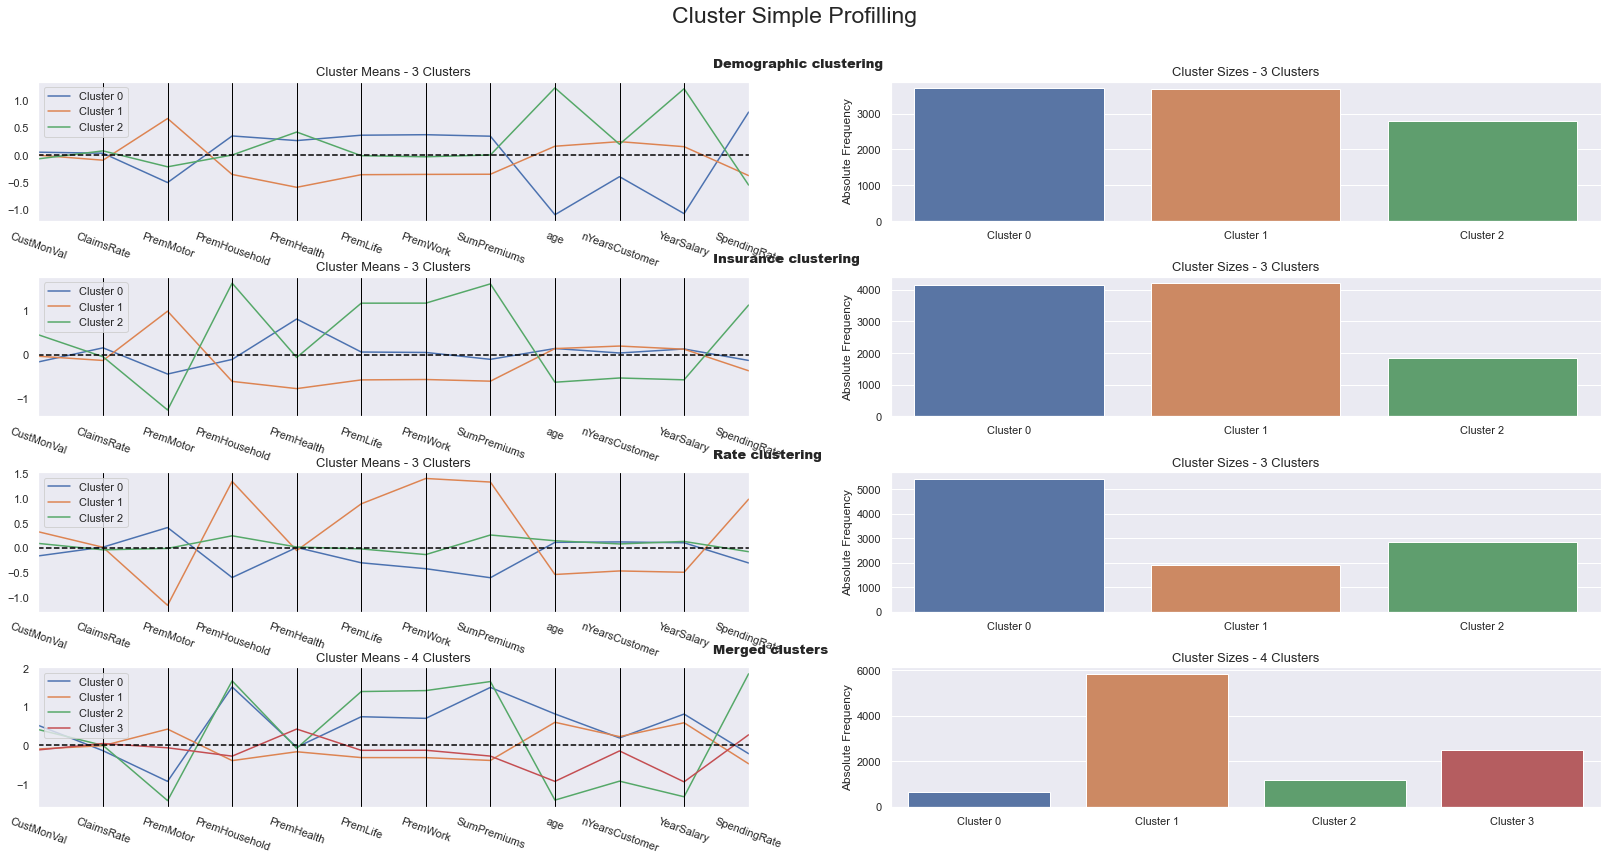

In [798]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = file_encode[metric_features + ['Demographic_labels', 'Insurance_labels','Rate_labels' ,'merged_labels']], 
    label_columns = ['Demographic_labels', 'Insurance_labels','Rate_labels' ,'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Demographic clustering", "Insurance clustering", "Rate clustering ","Merged clusters"]
)

In [799]:
two_dim = TSNE(random_state=42).fit_transform(file_encode[metric_features])

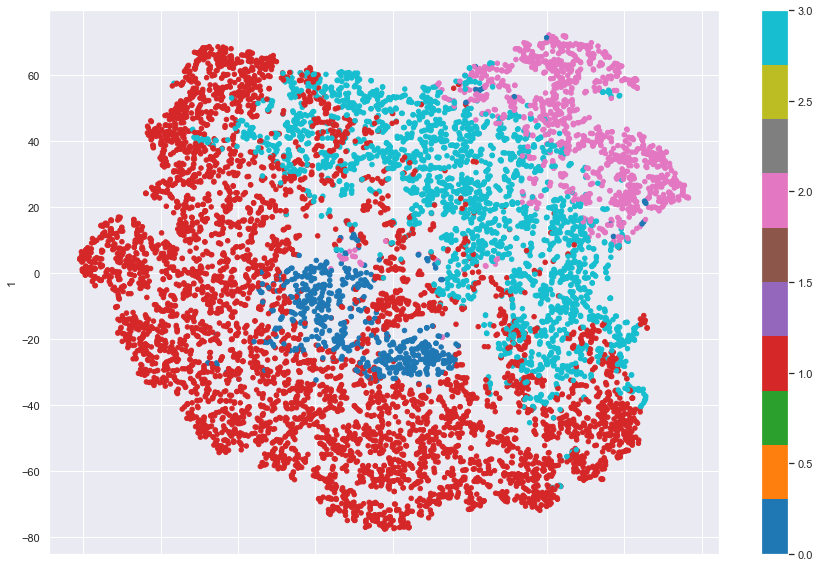

In [800]:
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=file_encode['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

In [801]:
import umap 


In [802]:
u =umap.UMAP(random_state=42).fit_transform(file_encode[metric_features])

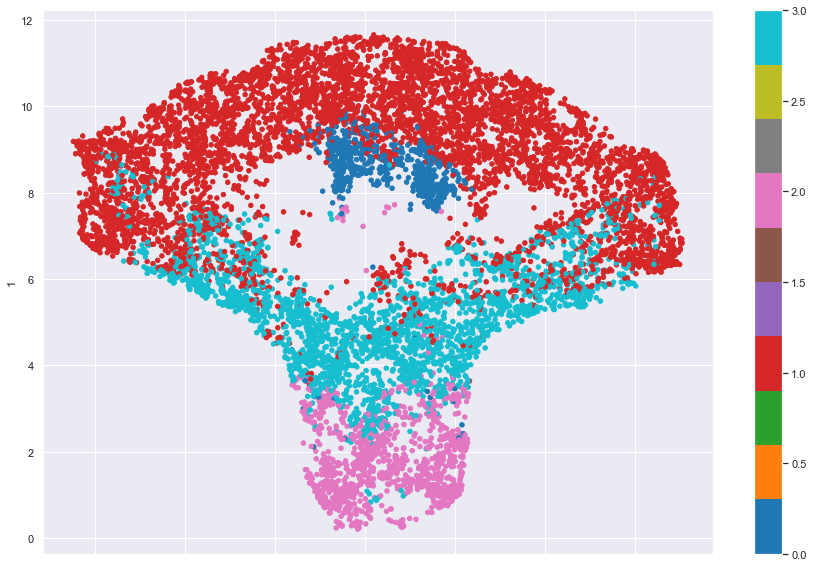

In [803]:
pd.DataFrame(u).plot.scatter(x=0, y=1, c=file_encode['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

### Profiling with Histograms

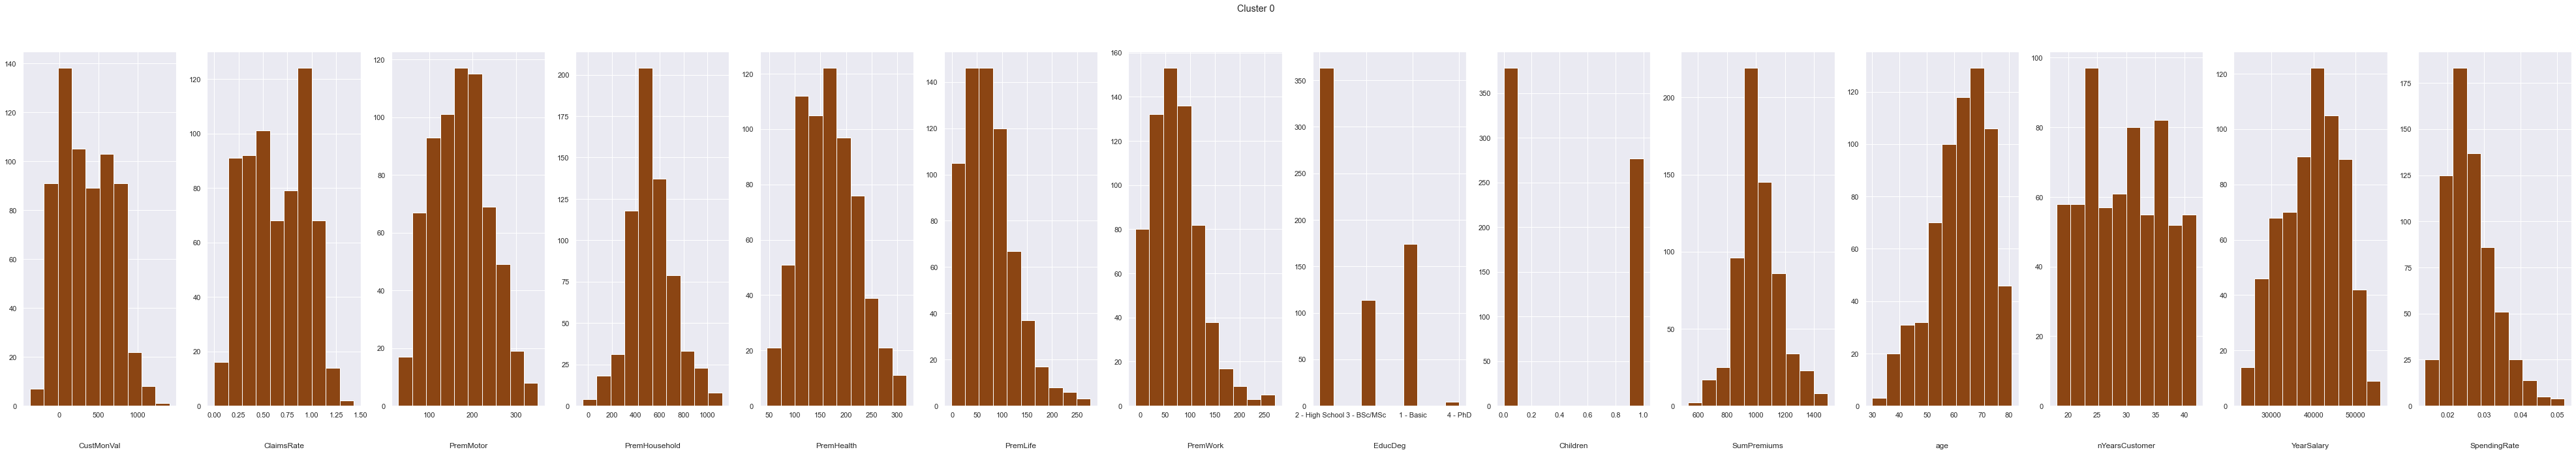

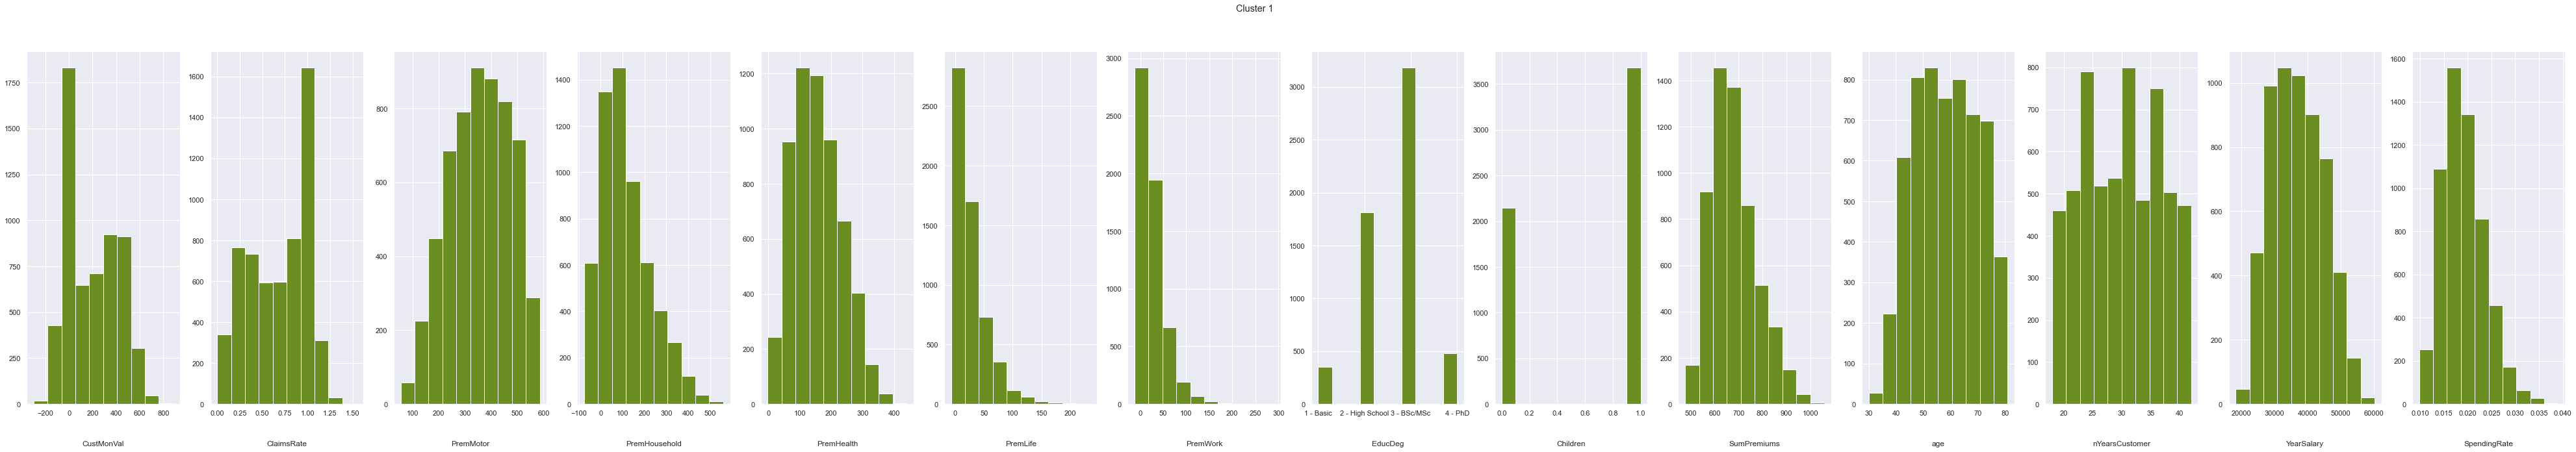

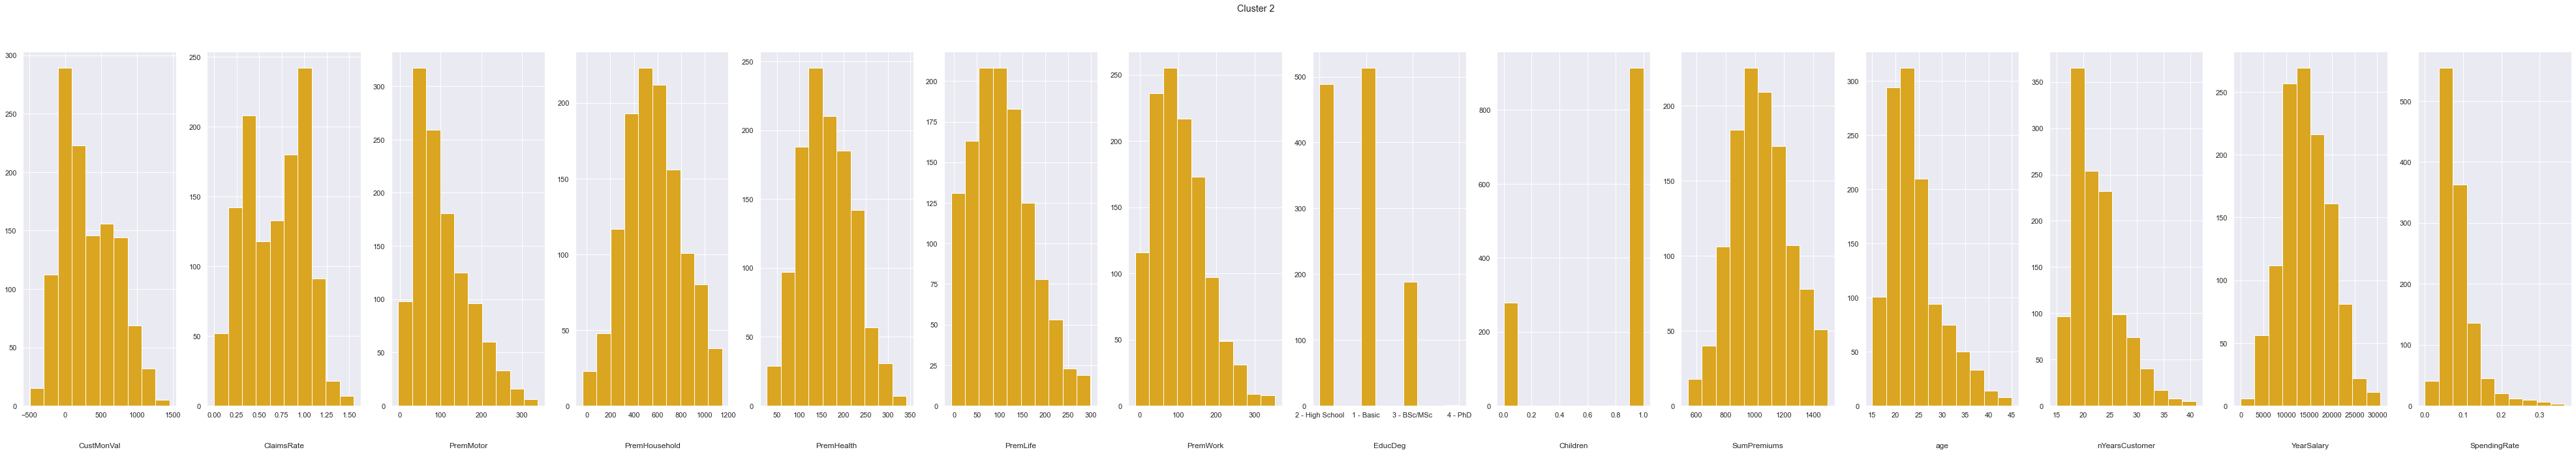

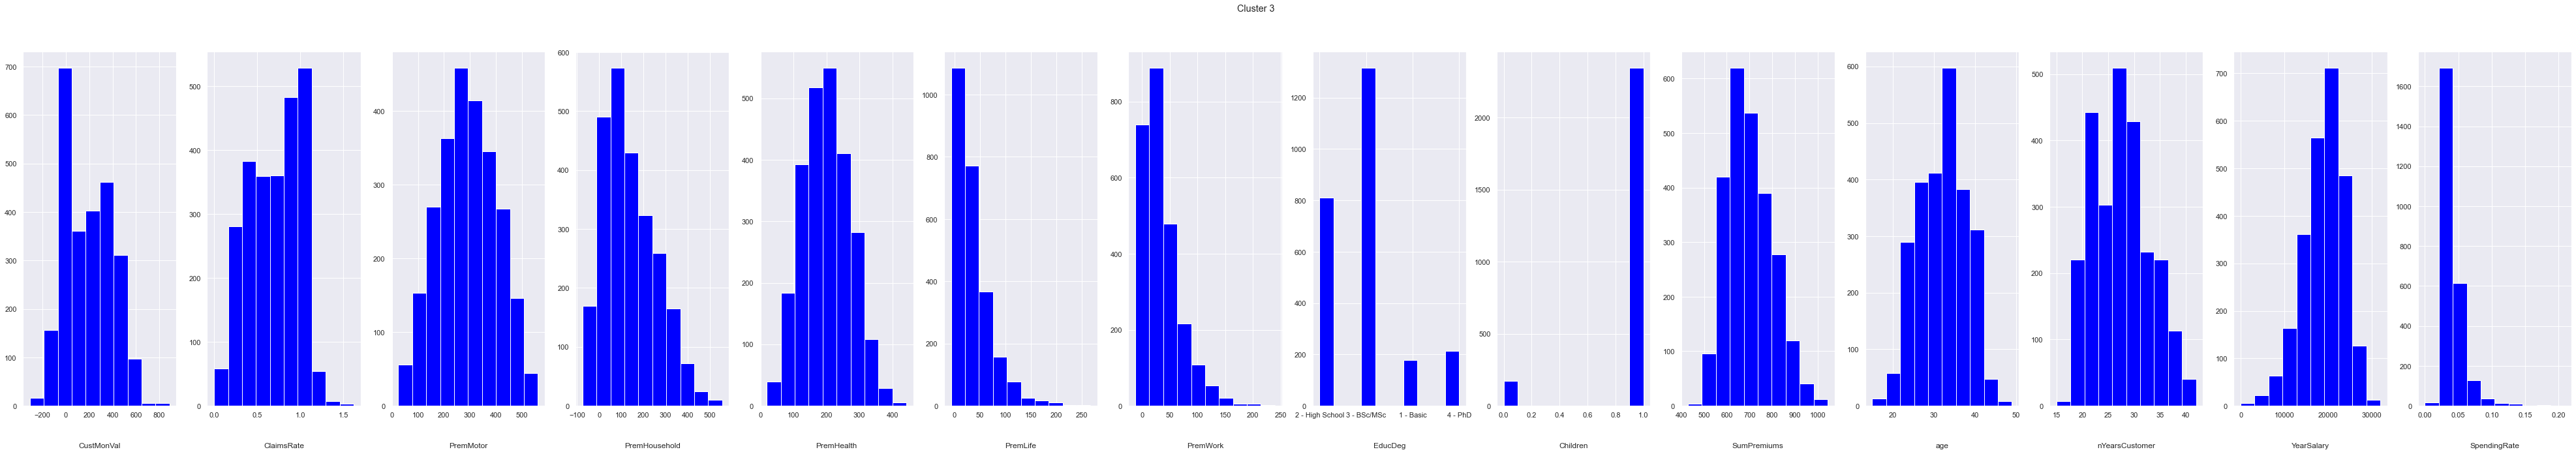

In [804]:
features = file_.iloc[:, 0: 14].columns.to_list()

#cluster 0 
merged_df_0 = file_[file_['merged_labels'] == 0]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(70, 10))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(merged_df_0[feat], color='saddlebrown')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 0'
plt.suptitle(title)

merged_df_1 = file_[file_['merged_labels'] == 1]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(70, 10))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(merged_df_1[feat], color='olivedrab')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 1'
plt.suptitle(title)

merged_df_2 = file_[file_['merged_labels'] == 2]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(70, 10))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(merged_df_2[feat], color='goldenrod')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 2'
plt.suptitle(title)
plt.show()

merged_df_3 = file_[file_['merged_labels'] == 3]
# All Numeric Variables' Histograms in one figure
sns.set()
        
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1, ceil(len(features) ), figsize=(70, 10))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
    ax.hist(merged_df_3[feat], color='blue')
    ax.set_title(feat, y=-0.13)
            
# Layout
# Add a centered title to the figure:
title = 'Cluster 3'
plt.suptitle(title)
plt.show()

